In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import albumentations as A
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from sklearn.utils import shuffle
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
NUM_WORKERS = 4
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
PIN_MEMORY = True
LOAD_MODEL = True

In [2]:
DATA_PATH = "kaggle_3m/"

dirs = []
images = []
masks = []
for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        if 'mask'in filename:
            dirs.append(dirname.replace(DATA_PATH, ''))
            masks.append(filename)
            images.append(filename.replace('_mask', ''))
print(DEVICE)

cuda


In [3]:
def is_all_zero(index):
    return np.all((np.array(Image.open(imagePath_df["mask-path"][index]).convert("L")).astype(np.float32) == 0))

In [4]:
"""
Data directory for the masks and images
Format is TCGA_<institution-code>_<patient-id>_<slice-number>.tif
Each image is a slice MRI scan of the patient's brain, with a mask showing tumor area if present
"""

imagePath_df = pd.DataFrame({'directory':dirs, 'images': images, 'masks': masks})
imagePath_df['image-path'] = DATA_PATH + imagePath_df['directory'] + '/' + imagePath_df['images']
imagePath_df['mask-path'] = DATA_PATH + imagePath_df['directory'] + '/' + imagePath_df['masks']

# Create an equal split of healthy and tumorous data images
healthy_df = pd.DataFrame()
tumor_df = pd.DataFrame()

for idx in range(len(imagePath_df)):
    if is_all_zero(idx):
        healthy_df = healthy_df.append(imagePath_df.loc[idx])
    else:
        tumor_df = tumor_df.append(imagePath_df.loc[idx])

train_healthy , valid_healthy = train_test_split(healthy_df, test_size=0.2)
train_tumor , valid_tumor = train_test_split(tumor_df, test_size=0.2)
valid_healthy, test_healthy = train_test_split(valid_healthy, test_size=0.5)
valid_tumor, test_tumor = train_test_split(valid_tumor, test_size=0.5)
train = shuffle(pd.concat([train_tumor, train_healthy]))
test = shuffle(pd.concat([test_tumor, test_healthy]))
valid = shuffle(pd.concat([valid_tumor, valid_healthy]))

In [5]:
# Show image shape
imagePath = os.path.join(DATA_PATH, imagePath_df['directory'].iloc[0], imagePath_df['images'].iloc[0])
maskPath = os.path.join(DATA_PATH, imagePath_df['directory'].iloc[0], imagePath_df['masks'].iloc[0])
image = cv2.imread(imagePath)
mask = cv2.imread(maskPath)

image.shape, mask.shape

((256, 256, 3), (256, 256, 3))

In [6]:
def plot_image(i):

    imagePath = os.path.join(DATA_PATH, imagePath_df['directory'].iloc[i], imagePath_df['images'].iloc[i])
    maskPath = os.path.join(DATA_PATH, imagePath_df['directory'].iloc[i], imagePath_df['masks'].iloc[i])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    fig, axs = plt.subplots(1,3, figsize=[13,15])
    
    axs[0].imshow(image)
    axs[0].set_title('Brain MRI')
    
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    
    axs[2].imshow(image)
    axs[2].imshow(mask, alpha=0.4)
    axs[2].set_title('MRI with mask')
    
    plt.grid(False)
    plt.show()

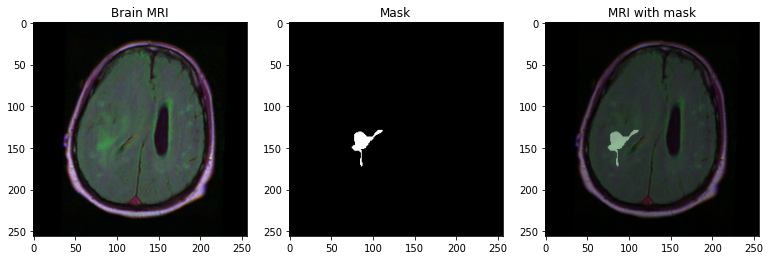

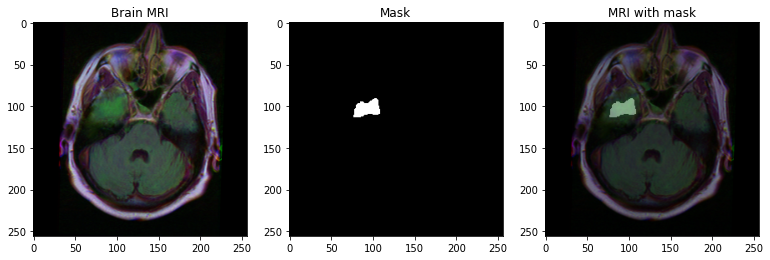

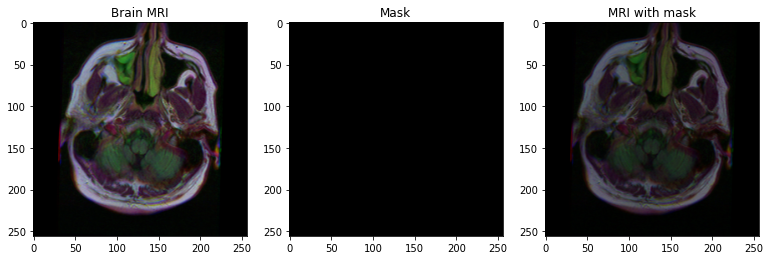

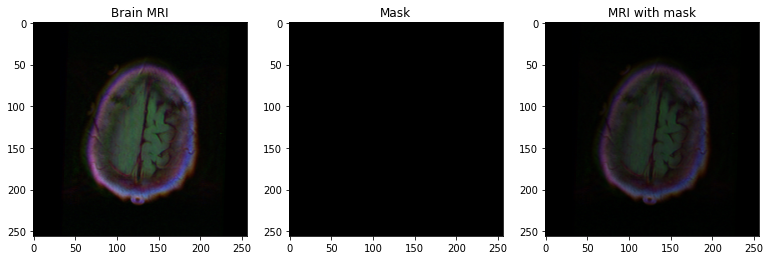

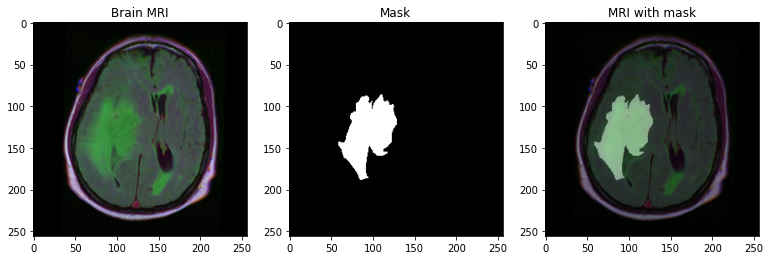

In [7]:
# Plot some example images
for i in range(5):
    plot_image(i)

In [8]:
# Training samples vs testing samples
len(train), len(test)

(3142, 394)

In [9]:
train

,directory,image-path,images,mask-path,masks
1123,TCGA_HT_8113_19930809,kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_1...,TCGA_HT_8113_19930809_12.tif,kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_1...,TCGA_HT_8113_19930809_12_mask.tif
3642,TCGA_DU_5872_19950223,kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_1...,TCGA_DU_5872_19950223_59.tif,kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_1...,TCGA_DU_5872_19950223_59_mask.tif
3644,TCGA_DU_5872_19950223,kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_1...,TCGA_DU_5872_19950223_14.tif,kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_1...,TCGA_DU_5872_19950223_14_mask.tif
3175,TCGA_FG_A4MU_20030903,kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_2...,TCGA_FG_A4MU_20030903_30.tif,kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_2...,TCGA_FG_A4MU_20030903_30_mask.tif
1663,TCGA_DU_7013_19860523,kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_1...,TCGA_DU_7013_19860523_28.tif,kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_1...,TCGA_DU_7013_19860523_28_mask.tif
...,...,...,...,...,...
849,TCGA_HT_8563_19981209,kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_1...,TCGA_HT_8563_19981209_18.tif,kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_1...,TCGA_HT_8563_19981209_18_mask.tif
2134,TCGA_DU_A5TR_19970726,kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_1...,TCGA_DU_A5TR_19970726_1.tif,kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_1...,TCGA_DU_A5TR_19970726_1_mask.tif
3177,TCGA_FG_A4MU_20030903,kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_2...,TCGA_FG_A4MU_20030903_31.tif,kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_2...,TCGA_FG_A4MU_20030903_31_mask.tif
3582,TCGA_DU_7301_19911112,kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_1...,TCGA_DU_7301_19911112_2.tif,kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_1...,TCGA_DU_7301_19911112_2_mask.tif


In [10]:
test

,directory,image-path,images,mask-path,masks
1604,TCGA_DU_6405_19851005,kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_1...,TCGA_DU_6405_19851005_40.tif,kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_1...,TCGA_DU_6405_19851005_40_mask.tif
2427,TCGA_DU_6399_19830416,kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_1...,TCGA_DU_6399_19830416_37.tif,kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_1...,TCGA_DU_6399_19830416_37_mask.tif
405,TCGA_HT_A61A_20000127,kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_2...,TCGA_HT_A61A_20000127_76.tif,kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_2...,TCGA_HT_A61A_20000127_76_mask.tif
239,TCGA_FG_6688_20020215,kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_2...,TCGA_FG_6688_20020215_33.tif,kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_2...,TCGA_FG_6688_20020215_33_mask.tif
3476,TCGA_DU_A5TW_19980228,kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_1...,TCGA_DU_A5TW_19980228_1.tif,kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_1...,TCGA_DU_A5TW_19980228_1_mask.tif
...,...,...,...,...,...
1097,TCGA_DU_A5TS_19970726,kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_1...,TCGA_DU_A5TS_19970726_18.tif,kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_1...,TCGA_DU_A5TS_19970726_18_mask.tif
1564,TCGA_DU_8166_19970322,kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_1...,TCGA_DU_8166_19970322_8.tif,kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_1...,TCGA_DU_8166_19970322_8_mask.tif
1540,TCGA_DU_8166_19970322,kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_1...,TCGA_DU_8166_19970322_3.tif,kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_1...,TCGA_DU_8166_19970322_3_mask.tif
3619,TCGA_DU_5872_19950223,kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_1...,TCGA_DU_5872_19950223_18.tif,kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_1...,TCGA_DU_5872_19950223_18_mask.tif


In [11]:
valid

,directory,image-path,images,mask-path,masks
3102,TCGA_DU_6400_19830518,kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_1...,TCGA_DU_6400_19830518_32.tif,kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_1...,TCGA_DU_6400_19830518_32_mask.tif
2478,TCGA_DU_6399_19830416,kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_1...,TCGA_DU_6399_19830416_18.tif,kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_1...,TCGA_DU_6399_19830416_18_mask.tif
1501,TCGA_HT_7884_19980913,kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_1...,TCGA_HT_7884_19980913_9.tif,kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_1...,TCGA_HT_7884_19980913_9_mask.tif
1228,TCGA_DU_7010_19860307,kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_1...,TCGA_DU_7010_19860307_29.tif,kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_1...,TCGA_DU_7010_19860307_29_mask.tif
3439,TCGA_DU_8164_19970111,kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_1...,TCGA_DU_8164_19970111_10.tif,kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_1...,TCGA_DU_8164_19970111_10_mask.tif
...,...,...,...,...,...
1747,TCGA_FG_A60K_20040224,kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_2...,TCGA_FG_A60K_20040224_73.tif,kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_2...,TCGA_FG_A60K_20040224_73_mask.tif
670,TCGA_HT_7475_19970918,kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_1...,TCGA_HT_7475_19970918_17.tif,kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_1...,TCGA_HT_7475_19970918_17_mask.tif
1280,TCGA_DU_6408_19860521,kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_1...,TCGA_DU_6408_19860521_45.tif,kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_1...,TCGA_DU_6408_19860521_45_mask.tif
446,TCGA_HT_A61A_20000127,kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_2...,TCGA_HT_A61A_20000127_29.tif,kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_2...,TCGA_HT_A61A_20000127_29_mask.tif


In [12]:
class BrainMRIDataset(Dataset):
    def __init__(self, image_list, mask_list, transform=None):
        self.images = list(image_list)
        self.masks = list(mask_list)
        self.transform = transform
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = np.array(Image.open(self.images[index]).convert("RGB"))
        mask = np.array(Image.open(self.masks[index]).convert("L")).astype(np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [13]:
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [14]:
train_ds = BrainMRIDataset(
    image_list=list(train["image-path"]),
    mask_list=list(train["mask-path"]),
    transform=train_transform,
)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
)

val_ds = BrainMRIDataset(
    image_list=list(test["image-path"]),
    mask_list=list(test["mask-path"]),
    transform=val_transform,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

test_ds = BrainMRIDataset(
    image_list=list(valid["image-path"]),
    mask_list=list(valid["mask-path"]),
    transform=val_transform,
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

Now we move on to defining the neural network, here is a basic network structure:
![UNet](UNet.png)

In [15]:
# First define the double convolution layer for u-net down
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [16]:
class UNET(nn.Module):
    def __init__(
        self, 
        in_channels=3, 
        out_channels=1, 
        features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
        
        # Lowest layer connecting up and down processes
        self.bottom_u = DoubleConv(features[-1], features[-1]*2)
        
        # Final convolution layer to output
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottom_u(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [17]:
# Define unet and move to GPU
unet = UNET(in_channels = 3, out_channels = 1)
unet.to(DEVICE)
# Batch size 1, 3 color channels, 256x256 image
test_forward = unet(torch.randn((1, 3, 256, 256)).cuda())
test_forward.shape

torch.Size([1, 1, 256, 256])

In [18]:
# Define checkpoint saving

def save_checkpoint(state, filename="checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

In [19]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} correct with an accuracy of {num_correct/num_pixels*100:.2f}"
    )
    score = dice_score/len(loader)
    print(f"Dice score: {score}")
    model.train()
    return score

In [20]:
def generate_predictions(
    loader, model, device="cuda"
):
    model.eval()
    predictions = []
    for x, y in loader:
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float().cpu()
            predictions.append((preds, y))
    return predictions

In [21]:
def plot_image(predictions, index):
    
    fig, axs = plt.subplots(1,5, figsize=[13,15])
    
    axs[0].imshow(val_ds[index][0].permute(1, 2, 0))
    axs[0].set_title('Brain MRI')
    
    axs[1].imshow(predictions[0][1][index])
    axs[1].set_title('Tumor')
    
    axs[2].imshow(val_ds[index][0].permute(1, 2, 0))
    axs[2].imshow(predictions[0][1][index], alpha=0.4)
    axs[2].set_title('Brain with tumor')
    
    axs[4].imshow(predictions[0][0][index].permute(1, 2, 0))
    axs[4].set_title('Predicted tumor')
    
    axs[3].imshow(val_ds[index][0].permute(1, 2, 0))
    axs[3].imshow(predictions[0][0][index].permute(1, 2, 0), alpha=0.4)
    axs[3].set_title('Brain with predicted tumor')
    
    plt.grid(False)
    plt.show()

In [22]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)
scaler = torch.cuda.amp.GradScaler()

In [23]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [24]:
score = 0
dice = []
learn_rate = []
valid_dice = []
worsen = 0
epochs = 0
# Train until we don't see improvement for 30 consequetive epochs
while worsen <= 30:
        train_fn(train_loader, unet, optimizer, loss_fn, scaler)

        # check accuracy
        new_score = check_accuracy(val_loader, unet, device=DEVICE)
        test_score = check_accuracy(test_loader, unet, device=DEVICE)
        valid_dice.append(test_score)
        dice.append(new_score)
        print('Epoch {0} lr: {1}'.format(epochs+1, optimizer.param_groups[0]['lr']))
        
        if (new_score > score):
            print("Better model, saving...")
            worsen = 0
            # save model
            checkpoint = {
                "state_dict": unet.state_dict(),
                "optimizer":optimizer.state_dict(),
            }
            save_checkpoint(checkpoint)
            score = new_score
        else:
            scheduler.step()
            print("Worse model, skipping...")
            worsen += 1
            # Reset learning rate in an attempt to escape local minima
            if worsen == 5:
                print("Spiking learning rate...")
                optimizer = optim.Adam(unet.parameters(), lr=1e-3)
                scheduler = StepLR(optimizer, step_size=2, gamma=0.1)
            
            # Bump assist
            if worsen == 15:
                optimizer = optim.Adam(unet.parameters(), lr=1e-3)
                scheduler = StepLR(optimizer, step_size=2, gamma=0.1)
        epochs += 1
        learn_rate.append(optimizer.param_groups[0]['lr'])

100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0813]


Got 25552600/25821184 correct with an accuracy of 98.96
Dice score: 0.0


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25506085/25755648 correct with an accuracy of 99.03
Dice score: 0.0
Epoch 1 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0317]


Got 25579562/25821184 correct with an accuracy of 99.06
Dice score: 0.6068041324615479
Got 25510876/25755648 correct with an accuracy of 99.05
Dice score: 0.5638845562934875
Epoch 2 lr: 0.001
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.48it/s, loss=0.043] 


Got 25652942/25821184 correct with an accuracy of 99.35
Dice score: 0.578798234462738


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25615374/25755648 correct with an accuracy of 99.46
Dice score: 0.6024489402770996
Epoch 3 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.49it/s, loss=0.0232]


Got 25678438/25821184 correct with an accuracy of 99.45
Dice score: 0.696702778339386
Got 25640085/25755648 correct with an accuracy of 99.55
Dice score: 0.7158678770065308
Epoch 4 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.48it/s, loss=0.0339]


Got 25683403/25821184 correct with an accuracy of 99.47
Dice score: 0.701193630695343
Got 25640640/25755648 correct with an accuracy of 99.55
Dice score: 0.7096814513206482
Epoch 5 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.48it/s, loss=0.0655]


Got 25684900/25821184 correct with an accuracy of 99.47
Dice score: 0.7259957790374756
Got 25640841/25755648 correct with an accuracy of 99.55
Dice score: 0.7306728363037109
Epoch 6 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.46it/s, loss=0.0251]


Got 25687174/25821184 correct with an accuracy of 99.48
Dice score: 0.7057563662528992


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25640478/25755648 correct with an accuracy of 99.55
Dice score: 0.7040326595306396
Epoch 7 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0232]


Got 25691614/25821184 correct with an accuracy of 99.50
Dice score: 0.7492570281028748
Got 25644255/25755648 correct with an accuracy of 99.57
Dice score: 0.7431241869926453
Epoch 8 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0233]


Got 25704917/25821184 correct with an accuracy of 99.55
Dice score: 0.7784594297409058
Got 25647863/25755648 correct with an accuracy of 99.58
Dice score: 0.7658836841583252
Epoch 9 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0145]


Got 25703693/25821184 correct with an accuracy of 99.54
Dice score: 0.7659283876419067


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25653103/25755648 correct with an accuracy of 99.60
Dice score: 0.7549228072166443
Epoch 10 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0115]


Got 25710725/25821184 correct with an accuracy of 99.57
Dice score: 0.7816534042358398
Got 25653835/25755648 correct with an accuracy of 99.60
Dice score: 0.7689689993858337
Epoch 11 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0151]


Got 25712626/25821184 correct with an accuracy of 99.58
Dice score: 0.7818763852119446
Got 25655833/25755648 correct with an accuracy of 99.61
Dice score: 0.7685824632644653
Epoch 12 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.48it/s, loss=0.0174]


Got 25708625/25821184 correct with an accuracy of 99.56
Dice score: 0.770814836025238


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25655140/25755648 correct with an accuracy of 99.61
Dice score: 0.7646095156669617
Epoch 13 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0197]


Got 25713482/25821184 correct with an accuracy of 99.58
Dice score: 0.7908066511154175
Got 25656750/25755648 correct with an accuracy of 99.62
Dice score: 0.7780317664146423
Epoch 14 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0257]


Got 25716685/25821184 correct with an accuracy of 99.60
Dice score: 0.8002988696098328
Got 25654198/25755648 correct with an accuracy of 99.61
Dice score: 0.7781866788864136
Epoch 15 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0233]


Got 25715135/25821184 correct with an accuracy of 99.59
Dice score: 0.7958143353462219


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25657293/25755648 correct with an accuracy of 99.62
Dice score: 0.782780647277832
Epoch 16 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0167]


Got 25715517/25821184 correct with an accuracy of 99.59
Dice score: 0.7888591885566711


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25658923/25755648 correct with an accuracy of 99.62
Dice score: 0.7774990797042847
Epoch 17 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0239]


Got 25716130/25821184 correct with an accuracy of 99.59
Dice score: 0.7979696989059448


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25657591/25755648 correct with an accuracy of 99.62
Dice score: 0.7831487655639648
Epoch 18 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.013] 


Got 25718901/25821184 correct with an accuracy of 99.60
Dice score: 0.8043765425682068
Got 25656886/25755648 correct with an accuracy of 99.62
Dice score: 0.7835566997528076
Epoch 19 lr: 1.0000000000000002e-07
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0213]


Got 25717808/25821184 correct with an accuracy of 99.60
Dice score: 0.8004050850868225


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25657109/25755648 correct with an accuracy of 99.62
Dice score: 0.7828516364097595
Epoch 20 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.46it/s, loss=0.00971]


Got 25714558/25821184 correct with an accuracy of 99.59
Dice score: 0.7851380109786987


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25658437/25755648 correct with an accuracy of 99.62
Dice score: 0.77362060546875
Epoch 21 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0106]


Got 25717881/25821184 correct with an accuracy of 99.60
Dice score: 0.8038272261619568


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25656782/25755648 correct with an accuracy of 99.62
Dice score: 0.7846609354019165
Epoch 22 lr: 1.0000000000000004e-08
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0107]


Got 25717944/25821184 correct with an accuracy of 99.60
Dice score: 0.7996374368667603


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25657963/25755648 correct with an accuracy of 99.62
Dice score: 0.7821241617202759
Epoch 23 lr: 1.0000000000000004e-08
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.48it/s, loss=0.0276]


Got 25716946/25821184 correct with an accuracy of 99.60
Dice score: 0.8047439455986023
Got 25653549/25755648 correct with an accuracy of 99.60
Dice score: 0.7823507189750671
Epoch 24 lr: 1.0000000000000005e-09
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.48it/s, loss=0.0158]


Got 25716928/25821184 correct with an accuracy of 99.60
Dice score: 0.7949069142341614


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25659245/25755648 correct with an accuracy of 99.63
Dice score: 0.7820436358451843
Epoch 25 lr: 1.0000000000000005e-09
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0298]


Got 25716993/25821184 correct with an accuracy of 99.60
Dice score: 0.793725311756134


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25658653/25755648 correct with an accuracy of 99.62
Dice score: 0.7795073986053467
Epoch 26 lr: 1.0000000000000005e-09
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.46it/s, loss=0.0192]


Got 25717099/25821184 correct with an accuracy of 99.60
Dice score: 0.7980815172195435


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25658144/25755648 correct with an accuracy of 99.62
Dice score: 0.7823808193206787
Epoch 27 lr: 1.0000000000000006e-10
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.46it/s, loss=0.0182]


Got 25717227/25821184 correct with an accuracy of 99.60
Dice score: 0.7959730625152588


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25658757/25755648 correct with an accuracy of 99.62
Dice score: 0.780856728553772
Epoch 28 lr: 1.0000000000000006e-10
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.46it/s, loss=0.0169]


Got 25717775/25821184 correct with an accuracy of 99.60
Dice score: 0.8002045750617981


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25657447/25755648 correct with an accuracy of 99.62
Dice score: 0.7829375863075256
Epoch 29 lr: 1.0000000000000006e-11
Worse model, skipping...
Spiking learning rate...


100%|██████████| 99/99 [00:22<00:00,  4.46it/s, loss=0.00973]


Got 25590138/25821184 correct with an accuracy of 99.11
Dice score: 0.6456183195114136


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25541212/25755648 correct with an accuracy of 99.17
Dice score: 0.630283772945404
Epoch 30 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.48it/s, loss=0.0196] 


Got 25671956/25821184 correct with an accuracy of 99.42
Dice score: 0.6501085162162781


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25623521/25755648 correct with an accuracy of 99.49
Dice score: 0.6376614570617676
Epoch 31 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.46it/s, loss=0.0154] 


Got 25697005/25821184 correct with an accuracy of 99.52
Dice score: 0.7469004392623901


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25647021/25755648 correct with an accuracy of 99.58
Dice score: 0.7407768368721008
Epoch 32 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.00854]


Got 25696894/25821184 correct with an accuracy of 99.52
Dice score: 0.7317903637886047


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25648177/25755648 correct with an accuracy of 99.58
Dice score: 0.729399561882019
Epoch 33 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0104] 


Got 25706545/25821184 correct with an accuracy of 99.56
Dice score: 0.7756263017654419


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25648889/25755648 correct with an accuracy of 99.59
Dice score: 0.7528581619262695
Epoch 34 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.00649]


Got 25703959/25821184 correct with an accuracy of 99.55
Dice score: 0.7591796517372131


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25650201/25755648 correct with an accuracy of 99.59
Dice score: 0.7444133758544922
Epoch 35 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0125] 


Got 25708159/25821184 correct with an accuracy of 99.56
Dice score: 0.7804409265518188


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25650060/25755648 correct with an accuracy of 99.59
Dice score: 0.7587176561355591
Epoch 36 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0162] 


Got 25705165/25821184 correct with an accuracy of 99.55
Dice score: 0.7645183205604553


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25650226/25755648 correct with an accuracy of 99.59
Dice score: 0.7467672824859619
Epoch 37 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.48it/s, loss=0.0112] 


Got 25706795/25821184 correct with an accuracy of 99.56
Dice score: 0.770580530166626


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25650644/25755648 correct with an accuracy of 99.59
Dice score: 0.7520409822463989
Epoch 38 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.48it/s, loss=0.0103] 


Got 25706976/25821184 correct with an accuracy of 99.56
Dice score: 0.7721204161643982


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25650027/25755648 correct with an accuracy of 99.59
Dice score: 0.749828577041626
Epoch 39 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.48it/s, loss=0.021]  


Got 25678963/25821184 correct with an accuracy of 99.45
Dice score: 0.7388063669204712


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25616587/25755648 correct with an accuracy of 99.46
Dice score: 0.7183489203453064
Epoch 40 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0189] 


Got 25685287/25821184 correct with an accuracy of 99.47
Dice score: 0.7063283920288086


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25634735/25755648 correct with an accuracy of 99.53
Dice score: 0.7048501372337341
Epoch 41 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.0109] 


Got 25706190/25821184 correct with an accuracy of 99.55
Dice score: 0.764129638671875


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25653317/25755648 correct with an accuracy of 99.60
Dice score: 0.7601718902587891
Epoch 42 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.48it/s, loss=0.031]  


Got 25715765/25821184 correct with an accuracy of 99.59
Dice score: 0.7898104190826416


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25658683/25755648 correct with an accuracy of 99.62
Dice score: 0.7718499302864075
Epoch 43 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0137] 


Got 25720017/25821184 correct with an accuracy of 99.61
Dice score: 0.8095872402191162
Got 25659349/25755648 correct with an accuracy of 99.63
Dice score: 0.7875089049339294
Epoch 44 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.48it/s, loss=0.00386]


Got 25719975/25821184 correct with an accuracy of 99.61
Dice score: 0.807240903377533


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25660638/25755648 correct with an accuracy of 99.63
Dice score: 0.7877725958824158
Epoch 45 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0373] 


Got 25716048/25821184 correct with an accuracy of 99.59
Dice score: 0.7896261215209961


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25659866/25755648 correct with an accuracy of 99.63
Dice score: 0.774685800075531
Epoch 46 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.49it/s, loss=0.0123] 


Got 25720636/25821184 correct with an accuracy of 99.61
Dice score: 0.8104860186576843
Got 25659204/25755648 correct with an accuracy of 99.63
Dice score: 0.7877193093299866
Epoch 47 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.48it/s, loss=0.0102] 


Got 25719957/25821184 correct with an accuracy of 99.61
Dice score: 0.809144914150238


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25659203/25755648 correct with an accuracy of 99.63
Dice score: 0.7878140211105347
Epoch 48 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:23<00:00,  4.20it/s, loss=0.0151] 


Got 25720140/25821184 correct with an accuracy of 99.61
Dice score: 0.8134993314743042
Got 25658391/25755648 correct with an accuracy of 99.62
Dice score: 0.7915276288986206
Epoch 49 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.48it/s, loss=0.0102] 


Got 25719367/25821184 correct with an accuracy of 99.61
Dice score: 0.8031885027885437


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25660328/25755648 correct with an accuracy of 99.63
Dice score: 0.7848178148269653
Epoch 50 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.48it/s, loss=0.0188] 


Got 25720609/25821184 correct with an accuracy of 99.61
Dice score: 0.8071423172950745


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25660835/25755648 correct with an accuracy of 99.63
Dice score: 0.7880881428718567
Epoch 51 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:24<00:00,  4.00it/s, loss=0.0559] 


Got 25718605/25821184 correct with an accuracy of 99.60
Dice score: 0.7989827990531921


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25660438/25755648 correct with an accuracy of 99.63
Dice score: 0.7818365097045898
Epoch 52 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:23<00:00,  4.15it/s, loss=0.0103] 


Got 25719992/25821184 correct with an accuracy of 99.61
Dice score: 0.8076978325843811


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25660483/25755648 correct with an accuracy of 99.63
Dice score: 0.7892245054244995
Epoch 53 lr: 1.0000000000000004e-08
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.35it/s, loss=0.0135] 


Got 25720874/25821184 correct with an accuracy of 99.61
Dice score: 0.8071249723434448


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25660865/25755648 correct with an accuracy of 99.63
Dice score: 0.7877960205078125
Epoch 54 lr: 1.0000000000000004e-08
Worse model, skipping...
Spiking learning rate...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0168] 


Got 25682284/25821184 correct with an accuracy of 99.46
Dice score: 0.6804955005645752


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25635826/25755648 correct with an accuracy of 99.53
Dice score: 0.6936587691307068
Epoch 55 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.029]  


Got 25687497/25821184 correct with an accuracy of 99.48
Dice score: 0.6926659345626831


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25636143/25755648 correct with an accuracy of 99.54
Dice score: 0.6834940910339355
Epoch 56 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.014]  


Got 25719867/25821184 correct with an accuracy of 99.61
Dice score: 0.7974093556404114


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25661705/25755648 correct with an accuracy of 99.64
Dice score: 0.777181088924408
Epoch 57 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:23<00:00,  4.22it/s, loss=0.00564]


Got 25724204/25821184 correct with an accuracy of 99.62
Dice score: 0.8058683276176453


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25666249/25755648 correct with an accuracy of 99.65
Dice score: 0.7916375398635864
Epoch 58 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0161] 


Got 25725505/25821184 correct with an accuracy of 99.63
Dice score: 0.8115047812461853


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25666876/25755648 correct with an accuracy of 99.66
Dice score: 0.7962190508842468
Epoch 59 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0151] 


Got 25726637/25821184 correct with an accuracy of 99.63
Dice score: 0.8156257271766663
Got 25667340/25755648 correct with an accuracy of 99.66
Dice score: 0.7994000911712646
Epoch 60 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:23<00:00,  4.23it/s, loss=0.0233] 


Got 25726887/25821184 correct with an accuracy of 99.63
Dice score: 0.8184945583343506
Got 25667615/25755648 correct with an accuracy of 99.66
Dice score: 0.8015341758728027
Epoch 61 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.48it/s, loss=0.0187] 


Got 25726055/25821184 correct with an accuracy of 99.63
Dice score: 0.8162947297096252


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25667908/25755648 correct with an accuracy of 99.66
Dice score: 0.8016448616981506
Epoch 62 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:25<00:00,  3.91it/s, loss=0.00379]


Got 25726558/25821184 correct with an accuracy of 99.63
Dice score: 0.818004846572876


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25667919/25755648 correct with an accuracy of 99.66
Dice score: 0.8034994006156921
Epoch 63 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:25<00:00,  3.90it/s, loss=0.0193] 


Got 25727052/25821184 correct with an accuracy of 99.64
Dice score: 0.816754937171936


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25668125/25755648 correct with an accuracy of 99.66
Dice score: 0.8010262846946716
Epoch 64 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.46it/s, loss=0.007]  


Got 25727463/25821184 correct with an accuracy of 99.64
Dice score: 0.8199439644813538
Got 25668287/25755648 correct with an accuracy of 99.66
Dice score: 0.8037601113319397
Epoch 65 lr: 1.0000000000000002e-07
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.48it/s, loss=0.0149] 


Got 25724352/25821184 correct with an accuracy of 99.62
Dice score: 0.8051692247390747


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25666791/25755648 correct with an accuracy of 99.65
Dice score: 0.7925849556922913
Epoch 66 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.00441]


Got 25727603/25821184 correct with an accuracy of 99.64
Dice score: 0.8222702145576477
Got 25667978/25755648 correct with an accuracy of 99.66
Dice score: 0.8049600124359131
Epoch 67 lr: 1.0000000000000002e-07
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.00824]


Got 25727602/25821184 correct with an accuracy of 99.64
Dice score: 0.81882643699646


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25668251/25755648 correct with an accuracy of 99.66
Dice score: 0.8022127747535706
Epoch 68 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:23<00:00,  4.14it/s, loss=0.0141] 


Got 25727619/25821184 correct with an accuracy of 99.64
Dice score: 0.8214716911315918


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25668117/25755648 correct with an accuracy of 99.66
Dice score: 0.8044098615646362
Epoch 69 lr: 1.0000000000000004e-08
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0083] 


Got 25725043/25821184 correct with an accuracy of 99.63
Dice score: 0.8092257976531982


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25667225/25755648 correct with an accuracy of 99.66
Dice score: 0.7951464056968689
Epoch 70 lr: 1.0000000000000004e-08
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.46it/s, loss=0.00867]


Got 25726409/25821184 correct with an accuracy of 99.63
Dice score: 0.8242032527923584
Got 25666702/25755648 correct with an accuracy of 99.65
Dice score: 0.8074848055839539
Epoch 71 lr: 1.0000000000000005e-09
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:23<00:00,  4.22it/s, loss=0.0259] 


Got 25725673/25821184 correct with an accuracy of 99.63
Dice score: 0.8116259574890137


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25667609/25755648 correct with an accuracy of 99.66
Dice score: 0.7971571683883667
Epoch 72 lr: 1.0000000000000005e-09
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0159] 


Got 25726648/25821184 correct with an accuracy of 99.63
Dice score: 0.8199760913848877


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25667447/25755648 correct with an accuracy of 99.66
Dice score: 0.8039746880531311
Epoch 73 lr: 1.0000000000000005e-09
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.48it/s, loss=0.00384]


Got 25726906/25821184 correct with an accuracy of 99.63
Dice score: 0.8229426741600037


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25667117/25755648 correct with an accuracy of 99.66
Dice score: 0.8067782521247864
Epoch 74 lr: 1.0000000000000006e-10
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.00556]


Got 25727082/25821184 correct with an accuracy of 99.64
Dice score: 0.8224478363990784


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25667754/25755648 correct with an accuracy of 99.66
Dice score: 0.8060364723205566
Epoch 75 lr: 1.0000000000000006e-10
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.00673]


Got 25727249/25821184 correct with an accuracy of 99.64
Dice score: 0.8249892592430115
Got 25667085/25755648 correct with an accuracy of 99.66
Dice score: 0.807786762714386
Epoch 76 lr: 1.0000000000000006e-11
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0146] 


Got 25728042/25821184 correct with an accuracy of 99.64
Dice score: 0.8235779404640198


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25667849/25755648 correct with an accuracy of 99.66
Dice score: 0.8051619529724121
Epoch 77 lr: 1.0000000000000006e-11
Worse model, skipping...


100%|██████████| 99/99 [00:24<00:00,  4.00it/s, loss=0.00816]


Got 25726578/25821184 correct with an accuracy of 99.63
Dice score: 0.8232164978981018


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25667599/25755648 correct with an accuracy of 99.66
Dice score: 0.8086014986038208
Epoch 78 lr: 1.0000000000000006e-11
Worse model, skipping...


100%|██████████| 99/99 [00:25<00:00,  3.90it/s, loss=0.0132] 


Got 25726942/25821184 correct with an accuracy of 99.64
Dice score: 0.8211812376976013


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25667871/25755648 correct with an accuracy of 99.66
Dice score: 0.8059103488922119
Epoch 79 lr: 1.0000000000000006e-12
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0168] 


Got 25726115/25821184 correct with an accuracy of 99.63
Dice score: 0.8150216341018677


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25667923/25755648 correct with an accuracy of 99.66
Dice score: 0.8013880252838135
Epoch 80 lr: 1.0000000000000006e-12
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.00623]


Got 25723225/25821184 correct with an accuracy of 99.62
Dice score: 0.8020241260528564


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25666234/25755648 correct with an accuracy of 99.65
Dice score: 0.7895402312278748
Epoch 81 lr: 1.0000000000000007e-13
Worse model, skipping...
Spiking learning rate...


100%|██████████| 99/99 [00:22<00:00,  4.46it/s, loss=0.00819]


Got 25695941/25821184 correct with an accuracy of 99.51
Dice score: 0.7262943983078003


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25647988/25755648 correct with an accuracy of 99.58
Dice score: 0.7370737195014954
Epoch 82 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.46it/s, loss=0.0126] 


Got 25709395/25821184 correct with an accuracy of 99.57
Dice score: 0.7919408679008484


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25652693/25755648 correct with an accuracy of 99.60
Dice score: 0.7681495547294617
Epoch 83 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:25<00:00,  3.85it/s, loss=0.0114] 


Got 25724659/25821184 correct with an accuracy of 99.63
Dice score: 0.8202797174453735


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25665848/25755648 correct with an accuracy of 99.65
Dice score: 0.7995021939277649
Epoch 84 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.46it/s, loss=0.0173] 


Got 25730112/25821184 correct with an accuracy of 99.65
Dice score: 0.8277192115783691
Got 25671031/25755648 correct with an accuracy of 99.67
Dice score: 0.8076932430267334
Epoch 85 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:24<00:00,  4.09it/s, loss=0.00684]


Got 25731868/25821184 correct with an accuracy of 99.65
Dice score: 0.8292409181594849
Got 25671703/25755648 correct with an accuracy of 99.67
Dice score: 0.8073954582214355
Epoch 86 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.48it/s, loss=0.014]  


Got 25733425/25821184 correct with an accuracy of 99.66
Dice score: 0.8323255181312561
Got 25672971/25755648 correct with an accuracy of 99.68
Dice score: 0.8072938323020935
Epoch 87 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:26<00:00,  3.79it/s, loss=0.0165] 


Got 25733702/25821184 correct with an accuracy of 99.66
Dice score: 0.8298736214637756


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25674114/25755648 correct with an accuracy of 99.68
Dice score: 0.8087068796157837
Epoch 88 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.33it/s, loss=0.0075] 


Got 25735666/25821184 correct with an accuracy of 99.67
Dice score: 0.838319718837738
Got 25675560/25755648 correct with an accuracy of 99.69
Dice score: 0.819164514541626
Epoch 89 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0187] 


Got 25736709/25821184 correct with an accuracy of 99.67
Dice score: 0.8374460935592651


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25676815/25755648 correct with an accuracy of 99.69
Dice score: 0.8168507218360901
Epoch 90 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.46it/s, loss=0.014]  


Got 25735935/25821184 correct with an accuracy of 99.67
Dice score: 0.834151029586792


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25676306/25755648 correct with an accuracy of 99.69
Dice score: 0.8125720024108887
Epoch 91 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.00648]


Got 25737583/25821184 correct with an accuracy of 99.68
Dice score: 0.8415945172309875
Got 25676978/25755648 correct with an accuracy of 99.69
Dice score: 0.8208361864089966
Epoch 92 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.46it/s, loss=0.00774]


Got 25738147/25821184 correct with an accuracy of 99.68
Dice score: 0.8421356678009033
Got 25677496/25755648 correct with an accuracy of 99.70
Dice score: 0.8205273747444153
Epoch 93 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0148] 


Got 25737427/25821184 correct with an accuracy of 99.68
Dice score: 0.8393594622612


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25677725/25755648 correct with an accuracy of 99.70
Dice score: 0.818997323513031
Epoch 94 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.46it/s, loss=0.0205] 


Got 25737583/25821184 correct with an accuracy of 99.68
Dice score: 0.8403000235557556


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25677268/25755648 correct with an accuracy of 99.70
Dice score: 0.8192190527915955
Epoch 95 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.46it/s, loss=0.00744]


Got 25738552/25821184 correct with an accuracy of 99.68
Dice score: 0.8436130881309509
Got 25677442/25755648 correct with an accuracy of 99.70
Dice score: 0.8206872344017029
Epoch 96 lr: 1.0000000000000002e-07
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.46it/s, loss=0.00895]


Got 25736227/25821184 correct with an accuracy of 99.67
Dice score: 0.8351748585700989


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25676118/25755648 correct with an accuracy of 99.69
Dice score: 0.8120417594909668
Epoch 97 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0201] 


Got 25734864/25821184 correct with an accuracy of 99.67
Dice score: 0.8312074542045593


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25674974/25755648 correct with an accuracy of 99.69
Dice score: 0.8088553547859192
Epoch 98 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.45it/s, loss=0.00837]


Got 25738604/25821184 correct with an accuracy of 99.68
Dice score: 0.8440774083137512
Got 25677969/25755648 correct with an accuracy of 99.70
Dice score: 0.8234339356422424
Epoch 99 lr: 1.0000000000000004e-08
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.46it/s, loss=0.0177] 


Got 25737466/25821184 correct with an accuracy of 99.68
Dice score: 0.8409761786460876


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25677538/25755648 correct with an accuracy of 99.70
Dice score: 0.8213146924972534
Epoch 100 lr: 1.0000000000000004e-08
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.48it/s, loss=0.00495]


Got 25737524/25821184 correct with an accuracy of 99.68
Dice score: 0.842325747013092


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25676453/25755648 correct with an accuracy of 99.69
Dice score: 0.821179211139679
Epoch 101 lr: 1.0000000000000004e-08
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.46it/s, loss=0.00797]


Got 25738121/25821184 correct with an accuracy of 99.68
Dice score: 0.8462319374084473
Got 25676435/25755648 correct with an accuracy of 99.69
Dice score: 0.8241658210754395
Epoch 102 lr: 1.0000000000000005e-09
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0117] 


Got 25737790/25821184 correct with an accuracy of 99.68
Dice score: 0.8410688638687134


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25676987/25755648 correct with an accuracy of 99.69
Dice score: 0.8192718625068665
Epoch 103 lr: 1.0000000000000005e-09
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.46it/s, loss=0.0104] 


Got 25737758/25821184 correct with an accuracy of 99.68
Dice score: 0.8437219262123108


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25676543/25755648 correct with an accuracy of 99.69
Dice score: 0.8225042223930359
Epoch 104 lr: 1.0000000000000005e-09
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.46it/s, loss=0.00211]


Got 25737506/25821184 correct with an accuracy of 99.68
Dice score: 0.8398513197898865


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25676956/25755648 correct with an accuracy of 99.69
Dice score: 0.8185997605323792
Epoch 105 lr: 1.0000000000000006e-10
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.46it/s, loss=0.0136] 


Got 25738333/25821184 correct with an accuracy of 99.68
Dice score: 0.8426554203033447


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25678093/25755648 correct with an accuracy of 99.70
Dice score: 0.8216280937194824
Epoch 106 lr: 1.0000000000000006e-10
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0317] 


Got 25733878/25821184 correct with an accuracy of 99.66
Dice score: 0.8284965753555298


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25674320/25755648 correct with an accuracy of 99.68
Dice score: 0.8069613575935364
Epoch 107 lr: 1.0000000000000006e-11
Worse model, skipping...
Spiking learning rate...


100%|██████████| 99/99 [00:22<00:00,  4.46it/s, loss=0.0102] 


Got 25680663/25821184 correct with an accuracy of 99.46
Dice score: 0.6695918440818787


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25635780/25755648 correct with an accuracy of 99.53
Dice score: 0.6752590537071228
Epoch 108 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.00997]


Got 25718542/25821184 correct with an accuracy of 99.60
Dice score: 0.8052307367324829


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25662153/25755648 correct with an accuracy of 99.64
Dice score: 0.7885727286338806
Epoch 109 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:23<00:00,  4.14it/s, loss=0.00515]


Got 25738287/25821184 correct with an accuracy of 99.68
Dice score: 0.8424937725067139


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25676064/25755648 correct with an accuracy of 99.69
Dice score: 0.8200525641441345
Epoch 110 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.46it/s, loss=0.0123] 


Got 25740941/25821184 correct with an accuracy of 99.69
Dice score: 0.8442549109458923


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25678583/25755648 correct with an accuracy of 99.70
Dice score: 0.8197033405303955
Epoch 111 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0114] 


Got 25740823/25821184 correct with an accuracy of 99.69
Dice score: 0.8493552803993225
Got 25676210/25755648 correct with an accuracy of 99.69
Dice score: 0.8251097202301025
Epoch 112 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.0148] 


Got 25741821/25821184 correct with an accuracy of 99.69
Dice score: 0.845360517501831


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25678368/25755648 correct with an accuracy of 99.70
Dice score: 0.8201168179512024
Epoch 113 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.47it/s, loss=0.00848]


Got 25742238/25821184 correct with an accuracy of 99.69
Dice score: 0.8475728631019592


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25678875/25755648 correct with an accuracy of 99.70
Dice score: 0.8230987191200256
Epoch 114 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.46it/s, loss=0.0116] 


Got 25742105/25821184 correct with an accuracy of 99.69
Dice score: 0.852226972579956
Got 25679078/25755648 correct with an accuracy of 99.70
Dice score: 0.8291638493537903
Epoch 115 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.46it/s, loss=0.00426]


Got 25742525/25821184 correct with an accuracy of 99.70
Dice score: 0.84798264503479


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25680119/25755648 correct with an accuracy of 99.71
Dice score: 0.8243223428726196
Epoch 116 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.45it/s, loss=0.013]  


Got 25742096/25821184 correct with an accuracy of 99.69
Dice score: 0.8465145230293274


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25679509/25755648 correct with an accuracy of 99.70
Dice score: 0.8219832181930542
Epoch 117 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.0101] 


Got 25742589/25821184 correct with an accuracy of 99.70
Dice score: 0.8505139350891113


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25679935/25755648 correct with an accuracy of 99.71
Dice score: 0.8270523548126221
Epoch 118 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:23<00:00,  4.23it/s, loss=0.011]  


Got 25742388/25821184 correct with an accuracy of 99.69
Dice score: 0.8484938740730286


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25679878/25755648 correct with an accuracy of 99.71
Dice score: 0.8246100544929504
Epoch 119 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00734]


Got 25742498/25821184 correct with an accuracy of 99.70
Dice score: 0.8524328470230103
Got 25679041/25755648 correct with an accuracy of 99.70
Dice score: 0.8288292288780212
Epoch 120 lr: 1.0000000000000004e-08
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.44it/s, loss=0.0106] 


Got 25742683/25821184 correct with an accuracy of 99.70
Dice score: 0.8503336906433105


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25679155/25755648 correct with an accuracy of 99.70
Dice score: 0.8261808753013611
Epoch 121 lr: 1.0000000000000004e-08
Worse model, skipping...


100%|██████████| 99/99 [00:23<00:00,  4.14it/s, loss=0.00727]


Got 25742783/25821184 correct with an accuracy of 99.70
Dice score: 0.8504706025123596


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25681009/25755648 correct with an accuracy of 99.71
Dice score: 0.828125536441803
Epoch 122 lr: 1.0000000000000004e-08
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00634]


Got 25742222/25821184 correct with an accuracy of 99.69
Dice score: 0.8473833203315735


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25678841/25755648 correct with an accuracy of 99.70
Dice score: 0.8228958249092102
Epoch 123 lr: 1.0000000000000005e-09
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.44it/s, loss=0.00369]


Got 25742054/25821184 correct with an accuracy of 99.69
Dice score: 0.8458498120307922


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25679114/25755648 correct with an accuracy of 99.70
Dice score: 0.8208343982696533
Epoch 124 lr: 1.0000000000000005e-09
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00367]


Got 25742798/25821184 correct with an accuracy of 99.70
Dice score: 0.8522194027900696


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25680964/25755648 correct with an accuracy of 99.71
Dice score: 0.8309839963912964
Epoch 125 lr: 1.0000000000000006e-10
Worse model, skipping...
Spiking learning rate...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.00953]


Got 25715264/25821184 correct with an accuracy of 99.59
Dice score: 0.7978287935256958


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25655350/25755648 correct with an accuracy of 99.61
Dice score: 0.7781755328178406
Epoch 126 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.41it/s, loss=0.00558]


Got 25728267/25821184 correct with an accuracy of 99.64
Dice score: 0.8186866044998169


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25666072/25755648 correct with an accuracy of 99.65
Dice score: 0.773651659488678
Epoch 127 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.41it/s, loss=0.0029] 


Got 25742454/25821184 correct with an accuracy of 99.70
Dice score: 0.8479329943656921


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25680604/25755648 correct with an accuracy of 99.71
Dice score: 0.8207177519798279
Epoch 128 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.0157] 


Got 25744526/25821184 correct with an accuracy of 99.70
Dice score: 0.8540119528770447
Got 25683592/25755648 correct with an accuracy of 99.72
Dice score: 0.8330091834068298
Epoch 129 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.00199]


Got 25746880/25821184 correct with an accuracy of 99.71
Dice score: 0.8590414524078369
Got 25685198/25755648 correct with an accuracy of 99.73
Dice score: 0.8367968201637268
Epoch 130 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.41it/s, loss=0.00902]


Got 25747108/25821184 correct with an accuracy of 99.71
Dice score: 0.8606225848197937
Got 25684329/25755648 correct with an accuracy of 99.72
Dice score: 0.835311233997345
Epoch 131 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.0014] 


Got 25747918/25821184 correct with an accuracy of 99.72
Dice score: 0.8635727167129517
Got 25685373/25755648 correct with an accuracy of 99.73
Dice score: 0.838954746723175
Epoch 132 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.41it/s, loss=0.0152] 


Got 25749442/25821184 correct with an accuracy of 99.72
Dice score: 0.8673717975616455
Got 25686434/25755648 correct with an accuracy of 99.73
Dice score: 0.8425301909446716
Epoch 133 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.0144] 


Got 25748960/25821184 correct with an accuracy of 99.72
Dice score: 0.8603776097297668


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25685535/25755648 correct with an accuracy of 99.73
Dice score: 0.8314195871353149
Epoch 134 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.41it/s, loss=0.00715]


Got 25751020/25821184 correct with an accuracy of 99.73
Dice score: 0.8688700199127197
Got 25687008/25755648 correct with an accuracy of 99.73
Dice score: 0.8412051796913147
Epoch 135 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.00494]


Got 25750814/25821184 correct with an accuracy of 99.73
Dice score: 0.8688902854919434
Got 25687302/25755648 correct with an accuracy of 99.73
Dice score: 0.8426884412765503
Epoch 136 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.00768]


Got 25750884/25821184 correct with an accuracy of 99.73
Dice score: 0.8690515160560608
Got 25687241/25755648 correct with an accuracy of 99.73
Dice score: 0.8426982164382935
Epoch 137 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.41it/s, loss=0.00914]


Got 25751717/25821184 correct with an accuracy of 99.73
Dice score: 0.8706197142601013
Got 25687673/25755648 correct with an accuracy of 99.74
Dice score: 0.8432554602622986
Epoch 138 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.00361]


Got 25751520/25821184 correct with an accuracy of 99.73
Dice score: 0.8704939484596252


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25687768/25755648 correct with an accuracy of 99.74
Dice score: 0.8446201682090759
Epoch 139 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.41it/s, loss=0.00395]


Got 25751363/25821184 correct with an accuracy of 99.73
Dice score: 0.8695158362388611


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25687567/25755648 correct with an accuracy of 99.74
Dice score: 0.842988133430481
Epoch 140 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.00942]


Got 25751085/25821184 correct with an accuracy of 99.73
Dice score: 0.8698222637176514


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25686772/25755648 correct with an accuracy of 99.73
Dice score: 0.8426805734634399
Epoch 141 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.0102] 


Got 25751541/25821184 correct with an accuracy of 99.73
Dice score: 0.8702860474586487


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25687280/25755648 correct with an accuracy of 99.73
Dice score: 0.843202531337738
Epoch 142 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.39it/s, loss=0.0126] 


Got 25751580/25821184 correct with an accuracy of 99.73
Dice score: 0.8696693778038025


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25687800/25755648 correct with an accuracy of 99.74
Dice score: 0.8423731923103333
Epoch 143 lr: 1.0000000000000002e-07
Worse model, skipping...
Spiking learning rate...


100%|██████████| 99/99 [00:24<00:00,  4.11it/s, loss=0.0257] 


Got 25736022/25821184 correct with an accuracy of 99.67
Dice score: 0.8314411044120789


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25672248/25755648 correct with an accuracy of 99.68
Dice score: 0.7993428707122803
Epoch 144 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.0212] 


Got 25742961/25821184 correct with an accuracy of 99.70
Dice score: 0.8456355929374695


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25679073/25755648 correct with an accuracy of 99.70
Dice score: 0.8123269081115723
Epoch 145 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.39it/s, loss=0.0175] 


Got 25748457/25821184 correct with an accuracy of 99.72
Dice score: 0.8612658977508545


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25684527/25755648 correct with an accuracy of 99.72
Dice score: 0.834703266620636
Epoch 146 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.00578]


Got 25750593/25821184 correct with an accuracy of 99.73
Dice score: 0.867387056350708


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25686905/25755648 correct with an accuracy of 99.73
Dice score: 0.8429058194160461
Epoch 147 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.00402]


Got 25749996/25821184 correct with an accuracy of 99.72
Dice score: 0.8648684024810791


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25686309/25755648 correct with an accuracy of 99.73
Dice score: 0.8381279706954956
Epoch 148 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.00987]


Got 25751196/25821184 correct with an accuracy of 99.73
Dice score: 0.8671171069145203


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25687154/25755648 correct with an accuracy of 99.73
Dice score: 0.8399619460105896
Epoch 149 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.00303]


Got 25751477/25821184 correct with an accuracy of 99.73
Dice score: 0.869679868221283


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25687270/25755648 correct with an accuracy of 99.73
Dice score: 0.8426969647407532
Epoch 150 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.0122] 


Got 25750849/25821184 correct with an accuracy of 99.73
Dice score: 0.8658020496368408


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25687613/25755648 correct with an accuracy of 99.74
Dice score: 0.8396194577217102
Epoch 151 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.0154] 


Got 25751186/25821184 correct with an accuracy of 99.73
Dice score: 0.8669975996017456


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25687479/25755648 correct with an accuracy of 99.74
Dice score: 0.8406970500946045
Epoch 152 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.39it/s, loss=0.0266] 


Got 25750608/25821184 correct with an accuracy of 99.73
Dice score: 0.8657504320144653


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25686444/25755648 correct with an accuracy of 99.73
Dice score: 0.8389609456062317
Epoch 153 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.38it/s, loss=0.0121] 


Got 25725595/25821184 correct with an accuracy of 99.63
Dice score: 0.8322402238845825


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25665828/25755648 correct with an accuracy of 99.65
Dice score: 0.8153497576713562
Epoch 154 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.39it/s, loss=0.00658]


Got 25738083/25821184 correct with an accuracy of 99.68
Dice score: 0.8520039319992065


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25672351/25755648 correct with an accuracy of 99.68
Dice score: 0.8186615109443665
Epoch 155 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.39it/s, loss=0.00527]


Got 25751342/25821184 correct with an accuracy of 99.73
Dice score: 0.8711966276168823
Got 25688072/25755648 correct with an accuracy of 99.74
Dice score: 0.8448546528816223
Epoch 156 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.0207] 


Got 25752812/25821184 correct with an accuracy of 99.74
Dice score: 0.8750530481338501
Got 25688786/25755648 correct with an accuracy of 99.74
Dice score: 0.8469668626785278
Epoch 157 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.00409]


Got 25753747/25821184 correct with an accuracy of 99.74
Dice score: 0.8761577010154724
Got 25690024/25755648 correct with an accuracy of 99.75
Dice score: 0.8464291095733643
Epoch 158 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.00339]


Got 25754074/25821184 correct with an accuracy of 99.74
Dice score: 0.8780423998832703
Got 25688652/25755648 correct with an accuracy of 99.74
Dice score: 0.8465650677680969
Epoch 159 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.39it/s, loss=0.00851]


Got 25754853/25821184 correct with an accuracy of 99.74
Dice score: 0.8802730441093445
Got 25689891/25755648 correct with an accuracy of 99.74
Dice score: 0.8501698970794678
Epoch 160 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.0146] 


Got 25755465/25821184 correct with an accuracy of 99.75
Dice score: 0.8785861134529114


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25689705/25755648 correct with an accuracy of 99.74
Dice score: 0.8456712961196899
Epoch 161 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.39it/s, loss=0.0105] 


Got 25756033/25821184 correct with an accuracy of 99.75
Dice score: 0.8812689185142517
Got 25690403/25755648 correct with an accuracy of 99.75
Dice score: 0.8498173356056213
Epoch 162 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.39it/s, loss=0.00245]


Got 25756677/25821184 correct with an accuracy of 99.75
Dice score: 0.8814250826835632
Got 25691789/25755648 correct with an accuracy of 99.75
Dice score: 0.8502471446990967
Epoch 163 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.38it/s, loss=0.00554]


Got 25756071/25821184 correct with an accuracy of 99.75
Dice score: 0.8793356418609619


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25690206/25755648 correct with an accuracy of 99.75
Dice score: 0.8439203500747681
Epoch 164 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.38it/s, loss=0.0141] 


Got 25757319/25821184 correct with an accuracy of 99.75
Dice score: 0.8824408054351807
Got 25691430/25755648 correct with an accuracy of 99.75
Dice score: 0.8487209677696228
Epoch 165 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.39it/s, loss=0.0069] 


Got 25757537/25821184 correct with an accuracy of 99.75
Dice score: 0.8824346661567688


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25692282/25755648 correct with an accuracy of 99.75
Dice score: 0.8494820594787598
Epoch 166 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.38it/s, loss=0.00438]


Got 25757597/25821184 correct with an accuracy of 99.75
Dice score: 0.8847542405128479
Got 25691168/25755648 correct with an accuracy of 99.75
Dice score: 0.850645899772644
Epoch 167 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.39it/s, loss=0.00864]


Got 25757530/25821184 correct with an accuracy of 99.75
Dice score: 0.8833924531936646


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25692015/25755648 correct with an accuracy of 99.75
Dice score: 0.850130021572113
Epoch 168 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.39it/s, loss=0.00746]


Got 25757812/25821184 correct with an accuracy of 99.75
Dice score: 0.882972776889801


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25692330/25755648 correct with an accuracy of 99.75
Dice score: 0.8494441509246826
Epoch 169 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.33it/s, loss=0.0017] 


Got 25757496/25821184 correct with an accuracy of 99.75
Dice score: 0.8835176825523376


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25692158/25755648 correct with an accuracy of 99.75
Dice score: 0.8515172004699707
Epoch 170 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.39it/s, loss=0.00969]


Got 25757673/25821184 correct with an accuracy of 99.75
Dice score: 0.8833107948303223


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25691853/25755648 correct with an accuracy of 99.75
Dice score: 0.8505708575248718
Epoch 171 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.39it/s, loss=0.0023] 


Got 25757952/25821184 correct with an accuracy of 99.76
Dice score: 0.8838885426521301


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25691904/25755648 correct with an accuracy of 99.75
Dice score: 0.8502056002616882
Epoch 172 lr: 1.0000000000000002e-07
Worse model, skipping...
Spiking learning rate...


100%|██████████| 99/99 [00:22<00:00,  4.38it/s, loss=0.00543]


Got 25736172/25821184 correct with an accuracy of 99.67
Dice score: 0.8236299753189087


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25674409/25755648 correct with an accuracy of 99.68
Dice score: 0.7959412932395935
Epoch 173 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.37it/s, loss=0.0025] 


Got 25732908/25821184 correct with an accuracy of 99.66
Dice score: 0.8283329606056213


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25679924/25755648 correct with an accuracy of 99.71
Dice score: 0.8012328147888184
Epoch 174 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.38it/s, loss=0.00827]


Got 25757606/25821184 correct with an accuracy of 99.75
Dice score: 0.8816192746162415


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25691473/25755648 correct with an accuracy of 99.75
Dice score: 0.8460385799407959
Epoch 175 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.39it/s, loss=0.0174] 


Got 25758367/25821184 correct with an accuracy of 99.76
Dice score: 0.8837383389472961


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25692300/25755648 correct with an accuracy of 99.75
Dice score: 0.845706582069397
Epoch 176 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.38it/s, loss=0.00375]


Got 25758878/25821184 correct with an accuracy of 99.76
Dice score: 0.8855789303779602
Got 25692637/25755648 correct with an accuracy of 99.76
Dice score: 0.8477940559387207
Epoch 177 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.38it/s, loss=0.00918]


Got 25757956/25821184 correct with an accuracy of 99.76
Dice score: 0.883172869682312


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25692248/25755648 correct with an accuracy of 99.75
Dice score: 0.8477284908294678
Epoch 178 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.38it/s, loss=0.0052] 


Got 25758949/25821184 correct with an accuracy of 99.76
Dice score: 0.8853631615638733


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25692655/25755648 correct with an accuracy of 99.76
Dice score: 0.8481271266937256
Epoch 179 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.37it/s, loss=0.00232]


Got 25757929/25821184 correct with an accuracy of 99.76
Dice score: 0.8835260272026062


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25691980/25755648 correct with an accuracy of 99.75
Dice score: 0.8481237292289734
Epoch 180 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.39it/s, loss=8.28e-5]


Got 25758512/25821184 correct with an accuracy of 99.76
Dice score: 0.885819673538208
Got 25692262/25755648 correct with an accuracy of 99.75
Dice score: 0.8514629006385803
Epoch 181 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.38it/s, loss=0.00767]


Got 25759135/25821184 correct with an accuracy of 99.76
Dice score: 0.8862502574920654
Got 25692871/25755648 correct with an accuracy of 99.76
Dice score: 0.8499470949172974
Epoch 182 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.39it/s, loss=0.00703]


Got 25758415/25821184 correct with an accuracy of 99.76
Dice score: 0.8848350048065186


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25692438/25755648 correct with an accuracy of 99.75
Dice score: 0.848709225654602
Epoch 183 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.37it/s, loss=0.00239]


Got 25759146/25821184 correct with an accuracy of 99.76
Dice score: 0.8861194252967834


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25693104/25755648 correct with an accuracy of 99.76
Dice score: 0.8508951663970947
Epoch 184 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.38it/s, loss=0.00274]


Got 25759292/25821184 correct with an accuracy of 99.76
Dice score: 0.8865230679512024
Got 25692744/25755648 correct with an accuracy of 99.76
Dice score: 0.8483235836029053
Epoch 185 lr: 1.0000000000000002e-07
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.38it/s, loss=0.00371]


Got 25759192/25821184 correct with an accuracy of 99.76
Dice score: 0.8869223594665527
Got 25692420/25755648 correct with an accuracy of 99.75
Dice score: 0.8507182598114014
Epoch 186 lr: 1.0000000000000002e-07
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.38it/s, loss=0.00884]


Got 25759197/25821184 correct with an accuracy of 99.76
Dice score: 0.8864442706108093


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25692624/25755648 correct with an accuracy of 99.76
Dice score: 0.8497283458709717
Epoch 187 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.39it/s, loss=0.000734]


Got 25759294/25821184 correct with an accuracy of 99.76
Dice score: 0.8868482708930969


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25692783/25755648 correct with an accuracy of 99.76
Dice score: 0.8514247536659241
Epoch 188 lr: 1.0000000000000004e-08
Worse model, skipping...


100%|██████████| 99/99 [00:24<00:00,  4.09it/s, loss=3.81e-5]


Got 25758926/25821184 correct with an accuracy of 99.76
Dice score: 0.8858819603919983


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25692851/25755648 correct with an accuracy of 99.76
Dice score: 0.8502820134162903
Epoch 189 lr: 1.0000000000000004e-08
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.37it/s, loss=0.00556]


Got 25758785/25821184 correct with an accuracy of 99.76
Dice score: 0.8848415017127991


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25693155/25755648 correct with an accuracy of 99.76
Dice score: 0.8497558832168579
Epoch 190 lr: 1.0000000000000005e-09
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.37it/s, loss=0.00142]


Got 25758638/25821184 correct with an accuracy of 99.76
Dice score: 0.8863145112991333


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25692509/25755648 correct with an accuracy of 99.75
Dice score: 0.8515868782997131
Epoch 191 lr: 1.0000000000000005e-09
Worse model, skipping...
Spiking learning rate...


100%|██████████| 99/99 [00:22<00:00,  4.35it/s, loss=0.0124] 


Got 25739429/25821184 correct with an accuracy of 99.68
Dice score: 0.8509572148323059


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25678647/25755648 correct with an accuracy of 99.70
Dice score: 0.8314394950866699
Epoch 192 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.36it/s, loss=0.00705]


Got 25749715/25821184 correct with an accuracy of 99.72
Dice score: 0.8641809821128845


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25687646/25755648 correct with an accuracy of 99.74
Dice score: 0.8354995250701904
Epoch 193 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:24<00:00,  4.07it/s, loss=0.00232]


Got 25758304/25821184 correct with an accuracy of 99.76
Dice score: 0.8831082582473755


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25692869/25755648 correct with an accuracy of 99.76
Dice score: 0.8493813276290894
Epoch 194 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.36it/s, loss=0.0126] 


Got 25758804/25821184 correct with an accuracy of 99.76
Dice score: 0.8849157691001892


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25694103/25755648 correct with an accuracy of 99.76
Dice score: 0.8542941212654114
Epoch 195 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:26<00:00,  3.70it/s, loss=0.00248]


Got 25759245/25821184 correct with an accuracy of 99.76
Dice score: 0.885977029800415


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25694233/25755648 correct with an accuracy of 99.76
Dice score: 0.8551260232925415
Epoch 196 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.36it/s, loss=0.00814]


Got 25759165/25821184 correct with an accuracy of 99.76
Dice score: 0.885897696018219


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25693989/25755648 correct with an accuracy of 99.76
Dice score: 0.8539682626724243
Epoch 197 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.37it/s, loss=0.00747]


Got 25759184/25821184 correct with an accuracy of 99.76
Dice score: 0.8858415484428406


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25694074/25755648 correct with an accuracy of 99.76
Dice score: 0.8541194796562195
Epoch 198 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:23<00:00,  4.15it/s, loss=0.0161] 


Got 25759109/25821184 correct with an accuracy of 99.76
Dice score: 0.885656476020813


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25693829/25755648 correct with an accuracy of 99.76
Dice score: 0.8529267311096191
Epoch 199 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.37it/s, loss=0.00708]


Got 25758900/25821184 correct with an accuracy of 99.76
Dice score: 0.8854168057441711


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25694009/25755648 correct with an accuracy of 99.76
Dice score: 0.8537441492080688
Epoch 200 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:24<00:00,  4.08it/s, loss=0.00259]


Got 25759016/25821184 correct with an accuracy of 99.76
Dice score: 0.8855653405189514


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25693840/25755648 correct with an accuracy of 99.76
Dice score: 0.853217363357544
Epoch 201 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:24<00:00,  4.09it/s, loss=0.000121]


Got 25739289/25821184 correct with an accuracy of 99.68
Dice score: 0.8326431512832642


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25670571/25755648 correct with an accuracy of 99.67
Dice score: 0.7829422950744629
Epoch 202 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.35it/s, loss=0.0298] 


Got 25748699/25821184 correct with an accuracy of 99.72
Dice score: 0.8704740405082703


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25687892/25755648 correct with an accuracy of 99.74
Dice score: 0.8500091433525085
Epoch 203 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.36it/s, loss=0.00631]


Got 25759278/25821184 correct with an accuracy of 99.76
Dice score: 0.8853297233581543


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25693834/25755648 correct with an accuracy of 99.76
Dice score: 0.8499138951301575
Epoch 204 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:24<00:00,  4.02it/s, loss=0.00542]


Got 25759095/25821184 correct with an accuracy of 99.76
Dice score: 0.8864399194717407


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25693544/25755648 correct with an accuracy of 99.76
Dice score: 0.8518165946006775
Epoch 205 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.37it/s, loss=0.00228]


Got 25760150/25821184 correct with an accuracy of 99.76
Dice score: 0.8878366351127625
Got 25695016/25755648 correct with an accuracy of 99.76
Dice score: 0.8538075685501099
Epoch 206 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.37it/s, loss=0.00844]


Got 25759802/25821184 correct with an accuracy of 99.76
Dice score: 0.887347936630249


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25694594/25755648 correct with an accuracy of 99.76
Dice score: 0.8529314398765564
Epoch 207 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.37it/s, loss=0.0194] 


Got 25759756/25821184 correct with an accuracy of 99.76
Dice score: 0.8868439793586731


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25694476/25755648 correct with an accuracy of 99.76
Dice score: 0.8509399890899658
Epoch 208 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:25<00:00,  3.95it/s, loss=0.000212]


Got 25760235/25821184 correct with an accuracy of 99.76
Dice score: 0.8888612985610962
Got 25694823/25755648 correct with an accuracy of 99.76
Dice score: 0.8553442358970642
Epoch 209 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.37it/s, loss=0.00427]


Got 25760210/25821184 correct with an accuracy of 99.76
Dice score: 0.8886211514472961


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25695095/25755648 correct with an accuracy of 99.76
Dice score: 0.8555572628974915
Epoch 210 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.37it/s, loss=0.00126]


Got 25760409/25821184 correct with an accuracy of 99.76
Dice score: 0.8891296982765198
Got 25695118/25755648 correct with an accuracy of 99.76
Dice score: 0.8559073209762573
Epoch 211 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.37it/s, loss=0.00569]


Got 25760427/25821184 correct with an accuracy of 99.76
Dice score: 0.8893862366676331
Got 25694624/25755648 correct with an accuracy of 99.76
Dice score: 0.8553760051727295
Epoch 212 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.38it/s, loss=0.00596]


Got 25760590/25821184 correct with an accuracy of 99.77
Dice score: 0.889094889163971


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25695135/25755648 correct with an accuracy of 99.77
Dice score: 0.8543528914451599
Epoch 213 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:23<00:00,  4.29it/s, loss=0.00268]


Got 25760169/25821184 correct with an accuracy of 99.76
Dice score: 0.8887261152267456


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25694852/25755648 correct with an accuracy of 99.76
Dice score: 0.855609118938446
Epoch 214 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:23<00:00,  4.29it/s, loss=0.00346]


Got 25760394/25821184 correct with an accuracy of 99.76
Dice score: 0.8894087076187134
Got 25694892/25755648 correct with an accuracy of 99.76
Dice score: 0.855650007724762
Epoch 215 lr: 1.0000000000000002e-07
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.36it/s, loss=0.00847]


Got 25760412/25821184 correct with an accuracy of 99.76
Dice score: 0.8884610533714294


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25694895/25755648 correct with an accuracy of 99.76
Dice score: 0.8535683751106262
Epoch 216 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:23<00:00,  4.30it/s, loss=0.00906]


Got 25760421/25821184 correct with an accuracy of 99.76
Dice score: 0.8889352679252625


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25695003/25755648 correct with an accuracy of 99.76
Dice score: 0.8553057909011841
Epoch 217 lr: 1.0000000000000004e-08
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.37it/s, loss=0.00269]


Got 25760165/25821184 correct with an accuracy of 99.76
Dice score: 0.8886222243309021


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25695020/25755648 correct with an accuracy of 99.76
Dice score: 0.8547250628471375
Epoch 218 lr: 1.0000000000000004e-08
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.37it/s, loss=0.00473]


Got 25760070/25821184 correct with an accuracy of 99.76
Dice score: 0.8880775570869446


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25694762/25755648 correct with an accuracy of 99.76
Dice score: 0.8541795015335083
Epoch 219 lr: 1.0000000000000005e-09
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.38it/s, loss=0.00626]


Got 25760538/25821184 correct with an accuracy of 99.77
Dice score: 0.8892441987991333


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25694959/25755648 correct with an accuracy of 99.76
Dice score: 0.8550350069999695
Epoch 220 lr: 1.0000000000000005e-09
Worse model, skipping...
Spiking learning rate...


100%|██████████| 99/99 [00:22<00:00,  4.38it/s, loss=0.0111] 


Got 25754585/25821184 correct with an accuracy of 99.74
Dice score: 0.879484236240387


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25692018/25755648 correct with an accuracy of 99.75
Dice score: 0.8529093861579895
Epoch 221 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.39it/s, loss=0.00428]


Got 25751978/25821184 correct with an accuracy of 99.73
Dice score: 0.8700268864631653


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25686414/25755648 correct with an accuracy of 99.73
Dice score: 0.8280762434005737
Epoch 222 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.00621]


Got 25760497/25821184 correct with an accuracy of 99.76
Dice score: 0.8889711499214172


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25695903/25755648 correct with an accuracy of 99.77
Dice score: 0.8564612865447998
Epoch 223 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.0066] 


Got 25759288/25821184 correct with an accuracy of 99.76
Dice score: 0.8867980241775513


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25696461/25755648 correct with an accuracy of 99.77
Dice score: 0.8549004197120667
Epoch 224 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.00339]


Got 25760642/25821184 correct with an accuracy of 99.77
Dice score: 0.8895431160926819
Got 25696693/25755648 correct with an accuracy of 99.77
Dice score: 0.8570409417152405
Epoch 225 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00158]


Got 25760202/25821184 correct with an accuracy of 99.76
Dice score: 0.8891004920005798


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25696750/25755648 correct with an accuracy of 99.77
Dice score: 0.8586570024490356
Epoch 226 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.00995] 


Got 25760766/25821184 correct with an accuracy of 99.77
Dice score: 0.890352725982666
Got 25696792/25755648 correct with an accuracy of 99.77
Dice score: 0.8583307862281799
Epoch 227 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00608]


Got 25760708/25821184 correct with an accuracy of 99.77
Dice score: 0.8895767331123352


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25696737/25755648 correct with an accuracy of 99.77
Dice score: 0.8578274846076965
Epoch 228 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:23<00:00,  4.16it/s, loss=0.00397] 


Got 25760996/25821184 correct with an accuracy of 99.77
Dice score: 0.8905295729637146
Got 25696758/25755648 correct with an accuracy of 99.77
Dice score: 0.858508825302124
Epoch 229 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.41it/s, loss=0.00388]


Got 25760961/25821184 correct with an accuracy of 99.77
Dice score: 0.8907138109207153
Got 25697077/25755648 correct with an accuracy of 99.77
Dice score: 0.8596640825271606
Epoch 230 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00679]


Got 25760778/25821184 correct with an accuracy of 99.77
Dice score: 0.8901722431182861


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25696802/25755648 correct with an accuracy of 99.77
Dice score: 0.8587466478347778
Epoch 231 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.00139]


Got 25760792/25821184 correct with an accuracy of 99.77
Dice score: 0.889727771282196


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25696477/25755648 correct with an accuracy of 99.77
Dice score: 0.8574383854866028
Epoch 232 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.44it/s, loss=0.00806]


Got 25760415/25821184 correct with an accuracy of 99.76
Dice score: 0.8888128399848938


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25697127/25755648 correct with an accuracy of 99.77
Dice score: 0.8580917716026306
Epoch 233 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:24<00:00,  4.05it/s, loss=0.00352]


Got 25760321/25821184 correct with an accuracy of 99.76
Dice score: 0.8892491459846497


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25696739/25755648 correct with an accuracy of 99.77
Dice score: 0.8587153553962708
Epoch 234 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.00507]


Got 25760605/25821184 correct with an accuracy of 99.77
Dice score: 0.8893336057662964


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25697192/25755648 correct with an accuracy of 99.77
Dice score: 0.8577033877372742
Epoch 235 lr: 1.0000000000000004e-08
Worse model, skipping...
Spiking learning rate...


100%|██████████| 99/99 [00:23<00:00,  4.20it/s, loss=0.0117] 


Got 25756753/25821184 correct with an accuracy of 99.75
Dice score: 0.881066083908081


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25690890/25755648 correct with an accuracy of 99.75
Dice score: 0.8442539572715759
Epoch 236 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.37it/s, loss=0.00538]


Got 25757246/25821184 correct with an accuracy of 99.75
Dice score: 0.8824611306190491


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25694349/25755648 correct with an accuracy of 99.76
Dice score: 0.8535135984420776
Epoch 237 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.41it/s, loss=0.00936]


Got 25761498/25821184 correct with an accuracy of 99.77
Dice score: 0.8902655839920044


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25697845/25755648 correct with an accuracy of 99.78
Dice score: 0.8600296974182129
Epoch 238 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.41it/s, loss=0.0076] 


Got 25762180/25821184 correct with an accuracy of 99.77
Dice score: 0.8934985995292664
Got 25698683/25755648 correct with an accuracy of 99.78
Dice score: 0.8643575310707092
Epoch 239 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:23<00:00,  4.18it/s, loss=0.00783]


Got 25762485/25821184 correct with an accuracy of 99.77
Dice score: 0.8928555250167847


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25698839/25755648 correct with an accuracy of 99.78
Dice score: 0.8605573773384094
Epoch 240 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:26<00:00,  3.76it/s, loss=0.000743]


Got 25762310/25821184 correct with an accuracy of 99.77
Dice score: 0.8932220935821533


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25698665/25755648 correct with an accuracy of 99.78
Dice score: 0.8629791140556335
Epoch 241 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:23<00:00,  4.18it/s, loss=0.00757] 


Got 25762316/25821184 correct with an accuracy of 99.77
Dice score: 0.8941495418548584
Got 25698292/25755648 correct with an accuracy of 99.78
Dice score: 0.8634129166603088
Epoch 242 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.00232]


Got 25762667/25821184 correct with an accuracy of 99.77
Dice score: 0.8941786885261536
Got 25699025/25755648 correct with an accuracy of 99.78
Dice score: 0.8636505603790283
Epoch 243 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.41it/s, loss=0.0021] 


Got 25762523/25821184 correct with an accuracy of 99.77
Dice score: 0.8934966325759888


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25698605/25755648 correct with an accuracy of 99.78
Dice score: 0.8627989292144775
Epoch 244 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.41it/s, loss=0.00234]


Got 25762347/25821184 correct with an accuracy of 99.77
Dice score: 0.8939677476882935


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25698953/25755648 correct with an accuracy of 99.78
Dice score: 0.8646233081817627
Epoch 245 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.0027] 


Got 25762279/25821184 correct with an accuracy of 99.77
Dice score: 0.8931182026863098


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25698643/25755648 correct with an accuracy of 99.78
Dice score: 0.8637162446975708
Epoch 246 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.00419]


Got 25762004/25821184 correct with an accuracy of 99.77
Dice score: 0.8926769495010376


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25698944/25755648 correct with an accuracy of 99.78
Dice score: 0.8637751936912537
Epoch 247 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00168]


Got 25762588/25821184 correct with an accuracy of 99.77
Dice score: 0.8939467668533325


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699137/25755648 correct with an accuracy of 99.78
Dice score: 0.8644649982452393
Epoch 248 lr: 1.0000000000000002e-07
Worse model, skipping...
Spiking learning rate...


100%|██████████| 99/99 [00:22<00:00,  4.41it/s, loss=0.0032] 


Got 25754575/25821184 correct with an accuracy of 99.74
Dice score: 0.8781171441078186


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25691899/25755648 correct with an accuracy of 99.75
Dice score: 0.8460946679115295
Epoch 249 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.00426] 


Got 25749363/25821184 correct with an accuracy of 99.72
Dice score: 0.8718875050544739


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25685266/25755648 correct with an accuracy of 99.73
Dice score: 0.8389480710029602
Epoch 250 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.00185]


Got 25762790/25821184 correct with an accuracy of 99.77
Dice score: 0.8920238018035889


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25695204/25755648 correct with an accuracy of 99.77
Dice score: 0.8551317453384399
Epoch 251 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.00094]


Got 25762285/25821184 correct with an accuracy of 99.77
Dice score: 0.8917895555496216


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25695780/25755648 correct with an accuracy of 99.77
Dice score: 0.8588804602622986
Epoch 252 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.00746]


Got 25762669/25821184 correct with an accuracy of 99.77
Dice score: 0.8931053280830383


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25695949/25755648 correct with an accuracy of 99.77
Dice score: 0.8598352074623108
Epoch 253 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00625]


Got 25763423/25821184 correct with an accuracy of 99.78
Dice score: 0.8945263624191284
Got 25695912/25755648 correct with an accuracy of 99.77
Dice score: 0.8587828874588013
Epoch 254 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.41it/s, loss=0.0111] 


Got 25763181/25821184 correct with an accuracy of 99.78
Dice score: 0.8944984674453735


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25696145/25755648 correct with an accuracy of 99.77
Dice score: 0.860359787940979
Epoch 255 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00465]


Got 25763443/25821184 correct with an accuracy of 99.78
Dice score: 0.894371509552002


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25695881/25755648 correct with an accuracy of 99.77
Dice score: 0.8587490320205688
Epoch 256 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.00634]


Got 25762769/25821184 correct with an accuracy of 99.77
Dice score: 0.8933781385421753


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25696133/25755648 correct with an accuracy of 99.77
Dice score: 0.8591895699501038
Epoch 257 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.00121]


Got 25762897/25821184 correct with an accuracy of 99.77
Dice score: 0.8941245079040527


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25696343/25755648 correct with an accuracy of 99.77
Dice score: 0.8613804578781128
Epoch 258 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.0116] 


Got 25762639/25821184 correct with an accuracy of 99.77
Dice score: 0.8920711874961853


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25695850/25755648 correct with an accuracy of 99.77
Dice score: 0.8569416403770447
Epoch 259 lr: 1.0000000000000002e-07
Worse model, skipping...
Spiking learning rate...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.0146] 


Got 25753638/25821184 correct with an accuracy of 99.74
Dice score: 0.8776316046714783


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25691002/25755648 correct with an accuracy of 99.75
Dice score: 0.8383715152740479
Epoch 260 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.00665]


Got 25758258/25821184 correct with an accuracy of 99.76
Dice score: 0.8882527351379395


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25695060/25755648 correct with an accuracy of 99.76
Dice score: 0.8604607582092285
Epoch 261 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=6.21e-5]


Got 25762499/25821184 correct with an accuracy of 99.77
Dice score: 0.8934856653213501


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699984/25755648 correct with an accuracy of 99.78
Dice score: 0.8674032092094421
Epoch 262 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.00342]


Got 25762882/25821184 correct with an accuracy of 99.77
Dice score: 0.8945760130882263
Got 25700371/25755648 correct with an accuracy of 99.79
Dice score: 0.8679534792900085
Epoch 263 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00352]


Got 25763494/25821184 correct with an accuracy of 99.78
Dice score: 0.8953191041946411
Got 25699947/25755648 correct with an accuracy of 99.78
Dice score: 0.865800678730011
Epoch 264 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.000568]


Got 25763986/25821184 correct with an accuracy of 99.78
Dice score: 0.8941622376441956


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699436/25755648 correct with an accuracy of 99.78
Dice score: 0.8612521290779114
Epoch 265 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.00243]


Got 25764209/25821184 correct with an accuracy of 99.78
Dice score: 0.8964037299156189
Got 25699975/25755648 correct with an accuracy of 99.78
Dice score: 0.8656690120697021
Epoch 266 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.44it/s, loss=8.08e-6]


Got 25763970/25821184 correct with an accuracy of 99.78
Dice score: 0.8959086537361145


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25700078/25755648 correct with an accuracy of 99.78
Dice score: 0.8655710816383362
Epoch 267 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00212]


Got 25764142/25821184 correct with an accuracy of 99.78
Dice score: 0.8964238166809082
Got 25700075/25755648 correct with an accuracy of 99.78
Dice score: 0.8661720752716064
Epoch 268 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.44it/s, loss=0.00784]


Got 25764289/25821184 correct with an accuracy of 99.78
Dice score: 0.896462082862854
Got 25700204/25755648 correct with an accuracy of 99.78
Dice score: 0.8658003807067871
Epoch 269 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.44it/s, loss=0.0127] 


Got 25764664/25821184 correct with an accuracy of 99.78
Dice score: 0.8971242308616638
Got 25699901/25755648 correct with an accuracy of 99.78
Dice score: 0.8650335669517517
Epoch 270 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=9.53e-5]


Got 25764728/25821184 correct with an accuracy of 99.78
Dice score: 0.8971130847930908


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699595/25755648 correct with an accuracy of 99.78
Dice score: 0.8647792935371399
Epoch 271 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00783]


Got 25764595/25821184 correct with an accuracy of 99.78
Dice score: 0.8963176012039185


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699787/25755648 correct with an accuracy of 99.78
Dice score: 0.8638012409210205
Epoch 272 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.00395]


Got 25764818/25821184 correct with an accuracy of 99.78
Dice score: 0.8971524834632874
Got 25699580/25755648 correct with an accuracy of 99.78
Dice score: 0.8647137880325317
Epoch 273 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00706]


Got 25764574/25821184 correct with an accuracy of 99.78
Dice score: 0.8966041207313538


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699689/25755648 correct with an accuracy of 99.78
Dice score: 0.864247739315033
Epoch 274 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00185]


Got 25764792/25821184 correct with an accuracy of 99.78
Dice score: 0.8973882794380188
Got 25699873/25755648 correct with an accuracy of 99.78
Dice score: 0.8653789758682251
Epoch 275 lr: 1.0000000000000002e-07
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.44it/s, loss=8.66e-6]


Got 25764705/25821184 correct with an accuracy of 99.78
Dice score: 0.8976215720176697
Got 25699531/25755648 correct with an accuracy of 99.78
Dice score: 0.8657044768333435
Epoch 276 lr: 1.0000000000000002e-07
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.44it/s, loss=0.0206] 


Got 25764648/25821184 correct with an accuracy of 99.78
Dice score: 0.8968592286109924


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699865/25755648 correct with an accuracy of 99.78
Dice score: 0.864666759967804
Epoch 277 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.00453]


Got 25764824/25821184 correct with an accuracy of 99.78
Dice score: 0.8975886106491089


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699623/25755648 correct with an accuracy of 99.78
Dice score: 0.8650773167610168
Epoch 278 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00211]


Got 25764712/25821184 correct with an accuracy of 99.78
Dice score: 0.8971470594406128


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699933/25755648 correct with an accuracy of 99.78
Dice score: 0.865385115146637
Epoch 279 lr: 1.0000000000000004e-08
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00266]


Got 25764719/25821184 correct with an accuracy of 99.78
Dice score: 0.8976635336875916
Got 25699739/25755648 correct with an accuracy of 99.78
Dice score: 0.865811288356781
Epoch 280 lr: 1.0000000000000004e-08
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00592]


Got 25764836/25821184 correct with an accuracy of 99.78
Dice score: 0.8977010846138
Got 25699775/25755648 correct with an accuracy of 99.78
Dice score: 0.8656557202339172
Epoch 281 lr: 1.0000000000000004e-08
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.44it/s, loss=0.00253] 


Got 25764829/25821184 correct with an accuracy of 99.78
Dice score: 0.8976181745529175


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25700013/25755648 correct with an accuracy of 99.78
Dice score: 0.8659519553184509
Epoch 282 lr: 1.0000000000000004e-08
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00839]


Got 25764829/25821184 correct with an accuracy of 99.78
Dice score: 0.8971986174583435


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699874/25755648 correct with an accuracy of 99.78
Dice score: 0.8649861812591553
Epoch 283 lr: 1.0000000000000005e-09
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.00069]


Got 25764606/25821184 correct with an accuracy of 99.78
Dice score: 0.8976099491119385


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699774/25755648 correct with an accuracy of 99.78
Dice score: 0.866245448589325
Epoch 284 lr: 1.0000000000000005e-09
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.37it/s, loss=0.00357]


Got 25764447/25821184 correct with an accuracy of 99.78
Dice score: 0.8975743055343628


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699366/25755648 correct with an accuracy of 99.78
Dice score: 0.8659663796424866
Epoch 285 lr: 1.0000000000000006e-10
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00718]


Got 25764591/25821184 correct with an accuracy of 99.78
Dice score: 0.897387683391571


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699625/25755648 correct with an accuracy of 99.78
Dice score: 0.8654060959815979
Epoch 286 lr: 1.0000000000000006e-10
Worse model, skipping...
Spiking learning rate...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00786]


Got 25759566/25821184 correct with an accuracy of 99.76
Dice score: 0.8866417407989502


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25692281/25755648 correct with an accuracy of 99.75
Dice score: 0.8471623659133911
Epoch 287 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00377]


Got 25751594/25821184 correct with an accuracy of 99.73
Dice score: 0.8749039173126221


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25688054/25755648 correct with an accuracy of 99.74
Dice score: 0.8318586945533752
Epoch 288 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.0133] 


Got 25765448/25821184 correct with an accuracy of 99.78
Dice score: 0.8980545997619629
Got 25698017/25755648 correct with an accuracy of 99.78
Dice score: 0.8604286909103394
Epoch 289 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.44it/s, loss=0.00101]


Got 25766172/25821184 correct with an accuracy of 99.79
Dice score: 0.8995264768600464
Got 25697314/25755648 correct with an accuracy of 99.77
Dice score: 0.8617984056472778
Epoch 290 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.44it/s, loss=0.00756] 


Got 25766739/25821184 correct with an accuracy of 99.79
Dice score: 0.9017155170440674
Got 25698114/25755648 correct with an accuracy of 99.78
Dice score: 0.863898515701294
Epoch 291 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.45it/s, loss=0.0046] 


Got 25767053/25821184 correct with an accuracy of 99.79
Dice score: 0.9001211524009705


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25698607/25755648 correct with an accuracy of 99.78
Dice score: 0.861521303653717
Epoch 292 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.00092] 


Got 25765719/25821184 correct with an accuracy of 99.79
Dice score: 0.8986636400222778


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25698863/25755648 correct with an accuracy of 99.78
Dice score: 0.8638823628425598
Epoch 293 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00378]


Got 25766277/25821184 correct with an accuracy of 99.79
Dice score: 0.8997824788093567


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25698208/25755648 correct with an accuracy of 99.78
Dice score: 0.8628607988357544
Epoch 294 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00382]


Got 25766524/25821184 correct with an accuracy of 99.79
Dice score: 0.9005215167999268


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25698810/25755648 correct with an accuracy of 99.78
Dice score: 0.8643543124198914
Epoch 295 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.44it/s, loss=0.00749]


Got 25766588/25821184 correct with an accuracy of 99.79
Dice score: 0.9002964496612549


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25698853/25755648 correct with an accuracy of 99.78
Dice score: 0.8638500571250916
Epoch 296 lr: 1.0000000000000002e-06
Worse model, skipping...
Spiking learning rate...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00814]


Got 25762417/25821184 correct with an accuracy of 99.77
Dice score: 0.8892779350280762


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25694545/25755648 correct with an accuracy of 99.76
Dice score: 0.8495199680328369
Epoch 297 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.00891]


Got 25751871/25821184 correct with an accuracy of 99.73
Dice score: 0.8789871335029602


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25689590/25755648 correct with an accuracy of 99.74
Dice score: 0.8476221561431885
Epoch 298 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00309]


Got 25765340/25821184 correct with an accuracy of 99.78
Dice score: 0.898892879486084


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25698962/25755648 correct with an accuracy of 99.78
Dice score: 0.8647531867027283
Epoch 299 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.00312]


Got 25765939/25821184 correct with an accuracy of 99.79
Dice score: 0.9003834128379822


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699806/25755648 correct with an accuracy of 99.78
Dice score: 0.8671075105667114
Epoch 300 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00323]


Got 25766217/25821184 correct with an accuracy of 99.79
Dice score: 0.9002613425254822


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699675/25755648 correct with an accuracy of 99.78
Dice score: 0.86612868309021
Epoch 301 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00301]


Got 25765959/25821184 correct with an accuracy of 99.79
Dice score: 0.9004884958267212


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699766/25755648 correct with an accuracy of 99.78
Dice score: 0.8676686882972717
Epoch 302 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.44it/s, loss=0.00509]


Got 25766307/25821184 correct with an accuracy of 99.79
Dice score: 0.9010360240936279


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699962/25755648 correct with an accuracy of 99.78
Dice score: 0.8678621649742126
Epoch 303 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00934]


Got 25765955/25821184 correct with an accuracy of 99.79
Dice score: 0.90027916431427


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699754/25755648 correct with an accuracy of 99.78
Dice score: 0.8671656250953674
Epoch 304 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.41it/s, loss=0.00307] 


Got 25766339/25821184 correct with an accuracy of 99.79
Dice score: 0.9009284377098083


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699608/25755648 correct with an accuracy of 99.78
Dice score: 0.8674609661102295
Epoch 305 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.00643]


Got 25765982/25821184 correct with an accuracy of 99.79
Dice score: 0.9004263281822205


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699663/25755648 correct with an accuracy of 99.78
Dice score: 0.8676915168762207
Epoch 306 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00388]


Got 25759338/25821184 correct with an accuracy of 99.76
Dice score: 0.8889673948287964


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25693916/25755648 correct with an accuracy of 99.76
Dice score: 0.8632090091705322
Epoch 307 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.000589]


Got 25758096/25821184 correct with an accuracy of 99.76
Dice score: 0.8834951519966125


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25692951/25755648 correct with an accuracy of 99.76
Dice score: 0.8583701252937317
Epoch 308 lr: 0.001
Worse model, skipping...


100%|██████████| 99/99 [00:23<00:00,  4.14it/s, loss=0.00411]


Got 25765691/25821184 correct with an accuracy of 99.79
Dice score: 0.8991759419441223


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25700567/25755648 correct with an accuracy of 99.79
Dice score: 0.869718074798584
Epoch 309 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00106]


Got 25766048/25821184 correct with an accuracy of 99.79
Dice score: 0.8996694087982178


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699538/25755648 correct with an accuracy of 99.78
Dice score: 0.8680592775344849
Epoch 310 lr: 0.0001
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.38it/s, loss=0.00581]


Got 25766595/25821184 correct with an accuracy of 99.79
Dice score: 0.900370717048645


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25700136/25755648 correct with an accuracy of 99.78
Dice score: 0.8680744767189026
Epoch 311 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.000739]


Got 25766678/25821184 correct with an accuracy of 99.79
Dice score: 0.9008306860923767


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699647/25755648 correct with an accuracy of 99.78
Dice score: 0.8678104877471924
Epoch 312 lr: 1e-05
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.44it/s, loss=0.00219] 


Got 25766769/25821184 correct with an accuracy of 99.79
Dice score: 0.9009102582931519


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699784/25755648 correct with an accuracy of 99.78
Dice score: 0.8678807616233826
Epoch 313 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.44it/s, loss=0.00147]


Got 25766803/25821184 correct with an accuracy of 99.79
Dice score: 0.9011827111244202


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699516/25755648 correct with an accuracy of 99.78
Dice score: 0.8679635524749756
Epoch 314 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.00423] 


Got 25766703/25821184 correct with an accuracy of 99.79
Dice score: 0.9003278613090515


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699976/25755648 correct with an accuracy of 99.78
Dice score: 0.8676588535308838
Epoch 315 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.00334]


Got 25766635/25821184 correct with an accuracy of 99.79
Dice score: 0.9001861214637756


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699996/25755648 correct with an accuracy of 99.78
Dice score: 0.8674044609069824
Epoch 316 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 99/99 [00:23<00:00,  4.19it/s, loss=0.00394] 


Got 25766531/25821184 correct with an accuracy of 99.79
Dice score: 0.9003651738166809


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699841/25755648 correct with an accuracy of 99.78
Dice score: 0.8676456809043884
Epoch 317 lr: 1.0000000000000004e-08
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00317] 


Got 25766509/25821184 correct with an accuracy of 99.79
Dice score: 0.9002244472503662


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699826/25755648 correct with an accuracy of 99.78
Dice score: 0.867350697517395
Epoch 318 lr: 1.0000000000000004e-08
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00216]


Got 25766672/25821184 correct with an accuracy of 99.79
Dice score: 0.9008685350418091


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699972/25755648 correct with an accuracy of 99.78
Dice score: 0.8685879111289978
Epoch 319 lr: 1.0000000000000005e-09
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.00806] 


Got 25765965/25821184 correct with an accuracy of 99.79
Dice score: 0.8985703587532043


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699977/25755648 correct with an accuracy of 99.78
Dice score: 0.8662463426589966
Epoch 320 lr: 1.0000000000000005e-09
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.44it/s, loss=0.00344] 


Got 25766727/25821184 correct with an accuracy of 99.79
Dice score: 0.9007049798965454


  0%|          | 0/99 [00:00<?, ?it/s]

Got 25699779/25755648 correct with an accuracy of 99.78
Dice score: 0.8674794435501099
Epoch 321 lr: 1.0000000000000006e-10
Worse model, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.00226] 


Got 25766869/25821184 correct with an accuracy of 99.79
Dice score: 0.900901734828949
Got 25700065/25755648 correct with an accuracy of 99.78
Dice score: 0.8679681420326233
Epoch 322 lr: 1.0000000000000006e-10
Worse model, skipping...


In [25]:
# Load best model

load_checkpoint(torch.load("checkpoint.pth.tar"), unet)

=> Loading checkpoint


In [26]:
predictions = generate_predictions(val_loader, unet, "cuda")

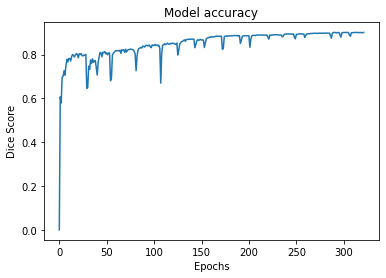

Got 25766739/25821184 correct with an accuracy of 99.79
Dice score: 0.9017155170440674


tensor(0.9017, device='cuda:0')

In [27]:
cpu_accuracy = [elem.cpu() for elem in dice]
x = np.arange(0, len(dice))
plt.title("Model accuracy")
plt.xlabel("Epochs")
plt.ylabel("Dice Score")
plt.plot(x, cpu_accuracy)
plt.show()
check_accuracy(val_loader, unet, device=DEVICE)

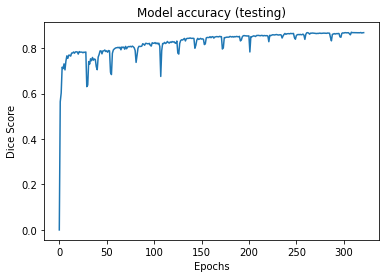

Got 25698114/25755648 correct with an accuracy of 99.78
Dice score: 0.863898515701294


tensor(0.8639, device='cuda:0')

In [33]:
cpu_dice_accuracy = [elem.cpu() for elem in valid_dice]
x = np.arange(0, len(dice))
plt.title("Model accuracy (testing)")
plt.xlabel("Epochs")
plt.ylabel("Dice Score")
plt.plot(x, cpu_dice_accuracy)
plt.show()
check_accuracy(test_loader, unet, device=DEVICE)

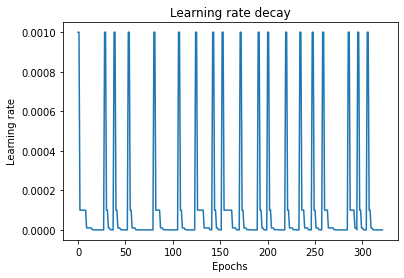

In [29]:
x = np.arange(0, len(learn_rate))
plt.title("Learning rate decay")
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.plot(x, learn_rate)
plt.show()

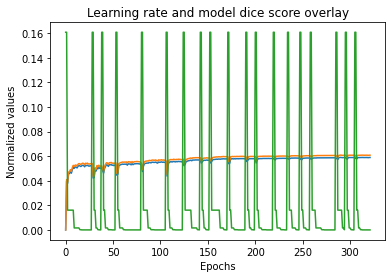

In [30]:
cpu_norm = cpu_accuracy / np.linalg.norm(cpu_accuracy)
cpu_dice_norm = cpu_accuracy / np.linalg.norm(cpu_dice_accuracy)
learn_norm = learn_rate / np.linalg.norm(learn_rate)
plt.plot(x, cpu_norm)
plt.plot(x, cpu_dice_norm)
plt.plot(x, learn_norm)
plt.xlabel("Epochs")
plt.ylabel("Normalized values")
plt.title("Learning rate and model dice score overlay")
plt.show()

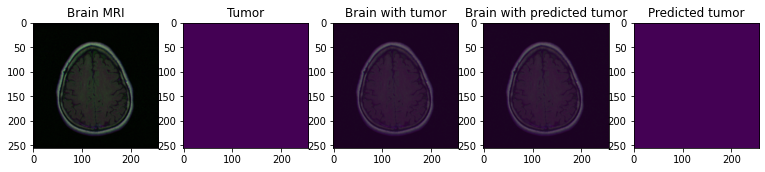

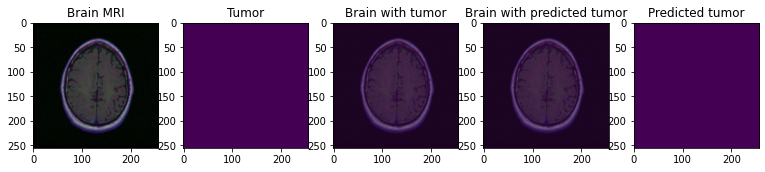

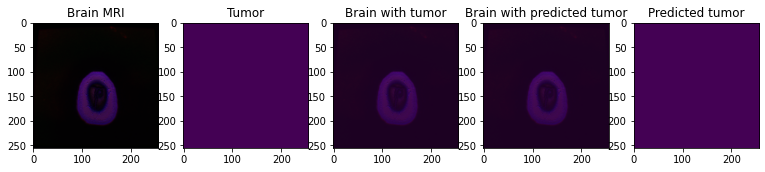

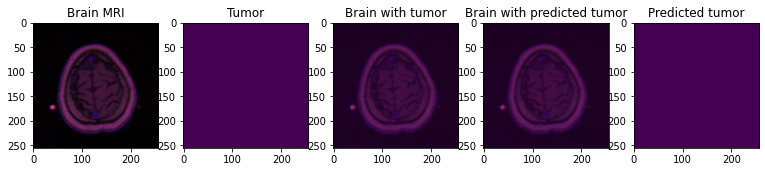

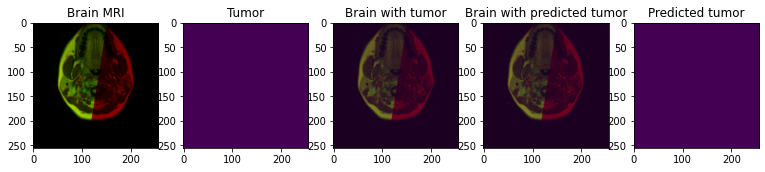

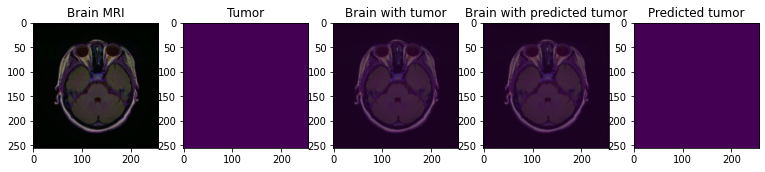

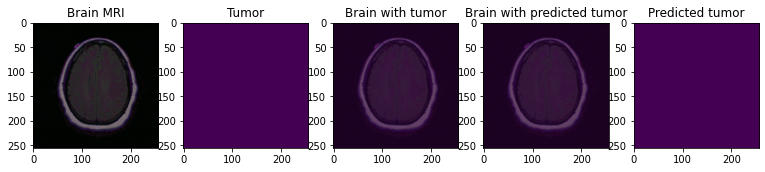

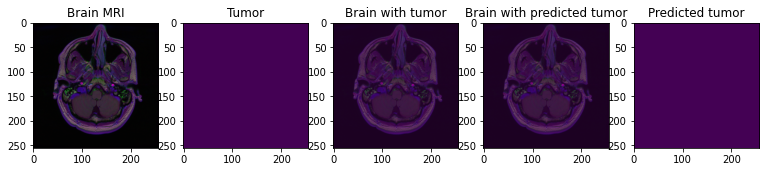

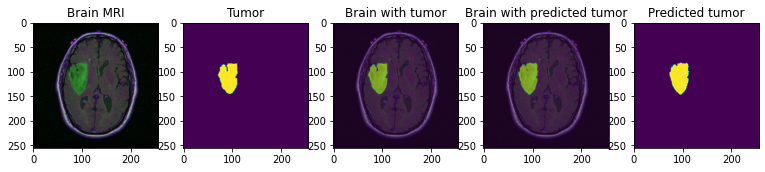

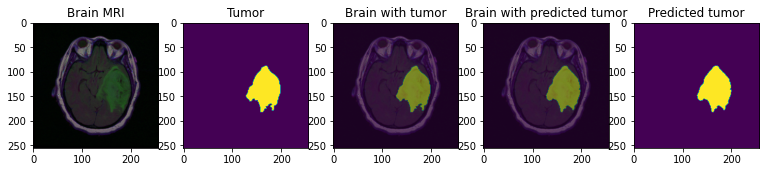

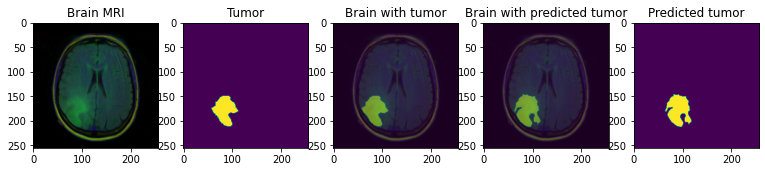

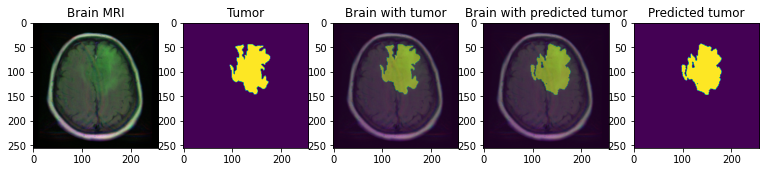

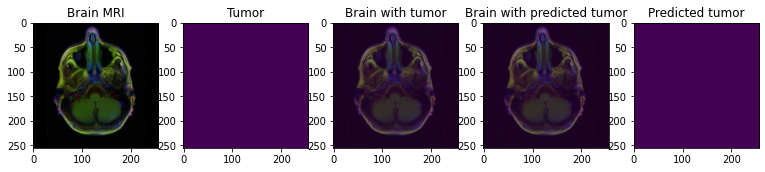

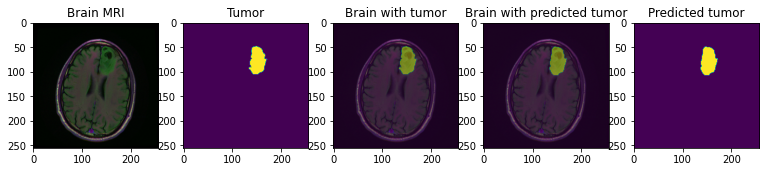

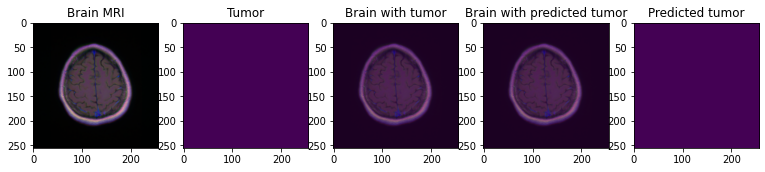

In [34]:
for i in range(15):
    plot_image(predictions, i)

In [32]:
check_accuracy(val_loader, unet, device=DEVICE)

Got 25766739/25821184 correct with an accuracy of 99.79
Dice score: 0.9017155170440674


tensor(0.9017, device='cuda:0')